# Coursera Capstone - Small Business Location Advisor  <a class='tocSkip'>
# Project Code  <a class='tocSkip'>

Prepared by John Christofolakos  
April 2019  
john.christofolakos@gmail.com

## Introduction

In the preparatory phase of the project, we:
- get geographical data on Toronto neighbourhoods
- retrieve a list of businesses in each neighbourhood including their type, price level, average rating.
- cluster the neighbourhoods according to the mix of businesses they contain. Including the average price level and rating in the clustering features was explored and deemed potentially useful.
- display a choropleth of GTA neighbourhoods by type.

During the usage phase, we will:
- obtain from the user the type of business they are proposing to open.
- for each neighbourhood type, fit a predictive model that uses the business data to predict the number of businesses of the given type.
- use the appropriate predictor for each neighbourhood to predict the expected number of business of the target type.
- compare the predicted business count to the actual business count and measure the degree of undersupply or oversupply.
- visualise the results as a choropleth map showing the degree of undersupply/oversupply for all neighbourhoods, and the locations of existing businesses of the proposed type.

Note that due to the complexity of the maps in this project, they could not be embedded directly and therefore willnot display on the downloaded notebook. Snapshots of each map have been placed in the file 'maps.zip'.

## Preparation

### Setup processing environment

First, we import the libraries we'll be using and setup some constants we need to access the FourSquare and Yelp API's.

In [1]:
import math
import time
import os
import functools
import numpy as np
import pandas as pd
import requests
import json
import bs4
from bs4 import BeautifulSoup

import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
import arcgis
from arcgis.gis import GIS
from arcgis.geocoding import geocode

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import pixiedust   # for debugging

import sklearn
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

print('pandas version ' + pd.__version__)
print('numpy version ' + np.__version__)
print('BeautifulSoup version ' + bs4.__version__)
print('matplotlib version ' + mpl.__version__)
print('Folium version ' + folium.__version__)
print('ArcGIS version' + arcgis.__version__)
print('sklearn version ' + sklearn.__version__)

Pixiedust database opened successfully


pandas version 0.23.4
numpy version 1.15.4
BeautifulSoup version 4.6.3
matplotlib version 3.0.2
Folium version 0.8.3
ArcGIS version1.6.0
sklearn version 0.20.1


In [2]:
# setup pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# setup to get venues from FourSquare
FOURSQUARE_VERSION = '20190401'

# setup to get businesses from Yelp
YELP_API_LIMIT = 50
YELP_SEARCH_LIMIT = 1000

# secrets should be placed in a JSON file with the following format:
#
# {
#     "FOURSQUARE_CLIENT_ID": "your FourSquare client ID",
#     "FOURSQUARE_CLIENT_SECRET": "your FourSquare client secret",
#     "YELP_BEARER_TOKEN": "your Yelp bearer token"
# }
with open('secrets.json', 'r') as s:
    secrets = json.load(s)

### Obtain neighbourhood name information

Wikipedia has a list of postal code prefixes (offically called Forward Sortation Areas or FSA's) mapped to a Borough name and a Neighbourhood name. We'll scrape it for some initial labelling data.

In [3]:
# get the Toronto neighbourhoods wiki page
def get_neighbourhood_info():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
    body = BeautifulSoup(resp.text, 'html.parser')
    #print(body.prettify())

    # scrape the neighbourhood data from the page
    rows = []
    tbl = body.find(class_='wikitable sortable')
    for row in tbl.find_all('tr'):
        cell_text = []
        for cell in row.find_all('td'):
            cell_text.append(cell.get_text().rstrip())
        if len(cell_text) == 3 and cell_text[1] != 'Not assigned':
            rows.append({'PostalCode': cell_text[0], 'Borough': cell_text[1], 'Neighbourhood': cell_text[2]})
            
    df = pd.DataFrame(columns=['PostalCode','Borough','Neighbourhood'])
    df = df.append(rows)
    return df


neighbourhood_df = get_neighbourhood_info()
print(neighbourhood_df.shape)
neighbourhood_df.head()

(211, 3)


,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


By examining the webpage itself, we can see that some adjustments are needed:
- some FSA codes are not assigned, these have already been dropped during retrieval.
- some neighbourhoods are listed as 'Not assigned', for these just copy the borough name.
- some FSA's have multiple neighbourhoods, aggregate these into a sngle entry, with a comma-separated list of neighbourhoods.
- some of the FSA's are just processing centers and don't really correspond with a geographical area - drop these.

Also, we will be appending various features (columns) to this dataframe from other dataframes, so it would be good to have PostalCode as an index so we ensure the rows in the two datframes line up. But choropleth maps want the postal code as a column. So let's create a duplicate postal code colum and set it as the index. We'll do the same for all our other dataframes.

In [4]:
def do_neighbourhood_fixups(df):
    # fix missing neighbourhood names
    assign_missing_neighbourhood = lambda row: (
            row['Borough'] if row['Neighbourhood'] == 'Not assigned' else row['Neighbourhood']
    )
    df['Neighbourhood'] = df.apply(assign_missing_neighbourhood, axis=1) 

    # aggregate multiple neighbourhoods in a postal code
    df.sort_values('PostalCode', inplace=True)
    df = pd.DataFrame(df.groupby(['PostalCode','Borough'])['Neighbourhood'].agg(lambda ser: ser.str.cat(sep=',')))
    df.reset_index(inplace=True)

    # drop postal processing centers
    df.drop(df[df['Neighbourhood'].str.contains('Processing Centre')].index, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df['FSA'] = df['PostalCode']
    df.set_index('FSA', inplace=True)
    df.head()
    return df


neighbourhood_df = do_neighbourhood_fixups(neighbourhood_df)
print(neighbourhood_df.shape)
neighbourhood_df.head()

(101, 3)


,PostalCode,Borough,Neighbourhood
FSA,,,
M1B,M1B,Scarborough,"Rouge,Malvern"
M1C,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek"
M1E,M1E,Scarborough,"Guildwood,Morningside,West Hill"
M1G,M1G,Scarborough,Woburn
M1H,M1H,Scarborough,Cedarbrae


### Obtain basic neighbourhood location information

Use the ArcGIS geocode module to find the location of each neighbourhood. You can query it by just passing in the 3-character FSA and it will return a latitude/longitude of roughly the center of the FSA, as well as the min and max latitude/longitude that define its bounding box.

In [5]:
# Get location of each neighbourhood. The geocode module will return a bounding box for
# each neighbourhood, let's check how that looks.
def get_neighbourhood_locations(df):
    gis = GIS()
    locations = []
    def get_location(loc):
        res = geocode(address=loc)
        locations.append([
            loc,
            res[0]['location']['y'],
            res[0]['location']['x'],
            res[0]['extent']['ymin'],
            res[0]['extent']['ymax'],
            res[0]['extent']['xmin'],
            res[0]['extent']['xmax']
        ])

    df['PostalCode'].map(lambda x: get_location(x))
    loc_df = pd.DataFrame(locations, columns=['FSA', 'Latitude','Longitude', 'LatitudeMin', 'LatitudeMax', 'LongitudeMin', 'LongitudeMax'])
    loc_df.set_index('FSA', inplace=True)

    return pd.concat([df, loc_df], axis=1)


neighbourhood_df = get_neighbourhood_locations(neighbourhood_df)
print(neighbourhood_df.head())
neighbourhood_df.shape

    PostalCode      Borough                         Neighbourhood   Latitude  Longitude  LatitudeMin  LatitudeMax  LongitudeMin  LongitudeMax
FSA                                                                                                                                          
M1B        M1B  Scarborough                         Rouge,Malvern  43.811525 -79.195517    43.749525    43.873525    -79.257517    -79.133517
M1C        M1C  Scarborough  Port Union,Rouge Hill,Highland Creek  43.785730 -79.158750    43.742730    43.828730    -79.201750    -79.115750
M1E        M1E  Scarborough       Guildwood,Morningside,West Hill  43.765690 -79.175256    43.715690    43.815690    -79.225256    -79.125256
M1G        M1G  Scarborough                                Woburn  43.768359 -79.217590    43.746359    43.790359    -79.239590    -79.195590
M1H        M1H  Scarborough                             Cedarbrae  43.769688 -79.239440    43.751688    43.787688    -79.257440    -79.221440


(101, 9)

In [6]:
# get the overall bounds of the GTA from the neighbourhood bounding boxes
gta_bounds = {
    'min_lat': neighbourhood_df['LatitudeMin'].min(),
    'max_lat': neighbourhood_df['LatitudeMax'].max(),
    'min_lon': neighbourhood_df['LongitudeMin'].min(),
    'max_lon': neighbourhood_df['LongitudeMax'].max(),
    'ctr_lat': (neighbourhood_df['Latitude'].max() + neighbourhood_df['Latitude'].min()) / 2,
    'ctr_lon': (neighbourhood_df['Longitude'].max() + neighbourhood_df['Longitude'].min()) / 2
}

Let's map that and see how it looks so far. Zoom level 11 was found to be a good fit for the GTA.

In [7]:
# map neighborhoods
map = folium.Map(location=[gta_bounds['ctr_lat'], gta_bounds['ctr_lon']], zoom_start=11)
for fsa, lat, lon, lat_min, lat_max, lon_min, lon_max, borough, neighbourhood in zip(
    neighbourhood_df['PostalCode'],
    neighbourhood_df['Latitude'],
    neighbourhood_df['Longitude'],
    neighbourhood_df['LatitudeMin'],
    neighbourhood_df['LatitudeMax'],
    neighbourhood_df['LongitudeMin'],
    neighbourhood_df['LongitudeMax'],
    neighbourhood_df['Borough'],
    neighbourhood_df['Neighbourhood']
):
    label = '{} - {}, {}'.format(fsa, neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)
    
    folium.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color='blue',
        weight=1,
        fill=False,
        parse_html=False
    ).add_to(map)

map

The bounding boxes from ArcGIS don't define the boundaries of the neighbourhoods very well, there's way too much overlap. We will look elsewhere for more detailed geodata on neighbourhood extents.

We'll use the minimum and maximum bounding box extents in order to define the bounday of the GTA as a whole, but drop the neighbourhood bounding box columns from our dataset.


In [8]:
# drop unneeded columns
neighbourhood_df.drop(columns=['LatitudeMax','LatitudeMin','LongitudeMax','LongitudeMin'], inplace=True)

### Obtain detailed neighbourhood geodata

Geo data giving the boundaries of the FSA's is available from Statistics Canada, the .shp format file was used:  
    https://www150.statcan.gc.ca/n1/en/catalogue/92-179-X.

The ogr2ogr utility from the GDAL site (https://www.gdal.org/ogr2ogr.html) was used to convert StatsCan's .shp file to .geojson format, reproject it to the EPSG:4326 spatial reference, and simplify the geometry a little:  
     `ogr2ogr -f GeoJSON -simplify 10 -t_srs EPSG:4326 canada_postalcodes_10.geojson lfsa000b16a_e.shp`

We can then load the geojson file in, and remove all the non-Toronto postal codes (those not starting with 'M').


In [9]:
# load the postalcodes geo file and filter out FSA's that don't start with 'M'
def get_neighbourhood_geo():
    with open('canada_postalcodes_10.geojson', 'r') as f:
        geo = json.load(f)
    newFeatures = [ feature for feature in geo['features'] if feature['properties']['CFSAUID'][0] == 'M' ]
    geo['features'] = newFeatures
    return geo


neighbourhood_geo = get_neighbourhood_geo()

Let's check against our list of neighbourhoods and see if they line up

In [10]:
# check if all of our neighbourhoods are in the GeoJSON file
def check_neighbourhoods_vs_geo(df, geo):
    get_fsa = lambda f: f['properties']['CFSAUID']
    geo_fsas = [ get_fsa(feature) for feature in geo['features'] ]
    return df.loc[ df['PostalCode'].isin(geo_fsas) == False ]
    
check_neighbourhoods_vs_geo(neighbourhood_df, neighbourhood_geo)

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
FSA,,,,,
M5K,M5K,Downtown Toronto,"Toronto Dominion Centre,Design Exchange",43.647100,-79.381531
M5L,M5L,Downtown Toronto,"Commerce Court,Victoria Hotel",43.648205,-79.378793
M5W,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.648690,-79.385440
M5X,M5X,Downtown Toronto,"Underground city,First Canadian Place",43.648280,-79.381461
M7A,M7A,Queen's Park,Queen's Park,43.661102,-79.391035


Some of our neighbourhood postal codes do not appear in the GeoJSON. Reading the docs from Stats Canada, this is because 'they were not the dominant FSA in
a dissemination area':
- M5K, M5L, M5X - these are buildings (and the basement floors thereof) in downtown Toronto, we can map them to neighbourhood M5H
- M5W - this is Postal Station A, mainly used for business reply mail - we can drop this from our neighborhoods
- M7A - Queen's Park, this is located in the M5S FSA so we'll map it to that neighbourhood



In [11]:
def remap_fsas_with_no_geo(df):
    map_fsas = {
        'M5K': 'M5H',
        'M5L': 'M5H',
        'M5X': 'M5H',
        'M5W': None,
        'M7A': 'M5S'
    }

    # we can drop those FSA's from our list of neighbourhood names
    df.drop(['M5K', 'M5L', 'M5X', 'M5W', 'M7A'], inplace=True)
    return map_fsas


# we'll use this map later when we're assigning businesses to neighbourhoods
map_fsas = remap_fsas_with_no_geo(neighbourhood_df)
neighbourhood_df.shape

(96, 5)

OK, now let's check if all of the FSA areas in the geoJSON file appear in our neighbourhoods list.

In [12]:
for f in neighbourhood_geo['features']:
    if not f['properties']['CFSAUID'] in list(neighbourhood_df['PostalCode']):
        print("FSA {} is not in the neighbourhoods dataframe".format(f['properties']['CFSAUID']))

No output, so our neighbourhoods list and the geo data are now lined up nicely. Let's map that and see how it looks. We need a little workaround because there is a problem drawing complex geometries directly in the notebook if using Chrome.

In [13]:
def embed_map(m):        # workaround for complex maps in Chrome
    from IPython.display import IFrame

    m.save('index.html')
    return IFrame('index.html', width='100%', height='750px')

# create a map centered on Toronto
map = folium.Map(location=[gta_bounds['ctr_lat'], gta_bounds['ctr_lon']], zoom_start=11)

# add a choropleth layer, just make everything light blue for now
folium.Choropleth(
    geo_data=neighbourhood_geo,
    fill_color='#AED6F1',
    fill_opacity=0.3,
    line_opacity=0.2
).add_to(map)

# draw a popup marker at the Wikipedia location of each neighbourhood
for lat, lng, postal_code, borough, neighbourhood in zip(
    neighbourhood_df['Latitude'],
    neighbourhood_df['Longitude'],
    neighbourhood_df['PostalCode'],
    neighbourhood_df['Borough'],
    neighbourhood_df['Neighbourhood']
):

    label = '{}-{}, {}'.format(postal_code, neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map)

# display the map
embed_map(map)

The neighbourhood boundaries look very good, thanks StasCan!

Looking closely, we see that some of the neighbourhood locations from ArcGIS are a bit off. Let's fix them up by referring to Google maps.

In [14]:
neighbourhood_df.loc[neighbourhood_df['PostalCode'] == 'M3K', 'Latitude'] = 43.731051        # ArcGIS has this just north of the FSA
neighbourhood_df.loc[neighbourhood_df['PostalCode'] == 'M1X', 'Longitude'] = -79.233928      # ArcGIS has this too far east
neighbourhood_df.loc[neighbourhood_df['PostalCode'] == 'M8Z', 'Longitude'] = -79.515713      # ArcGIS has this too far west

There are a few more where the marker isn't exactly well-centered, but let's not get fussy.

Let's see if the neighbourhood bounding boxes from ArcGIS are a reasonable bounding box for the Greater Toronto Area at least.

Redraw the map and check everything looks good.

In [15]:
# create a map centered on Toronto
map = folium.Map(location=[gta_bounds['ctr_lat'], gta_bounds['ctr_lon']], zoom_start=11)

# add a choropleth layer, just make everything light blue for now
folium.Choropleth(
    geo_data=neighbourhood_geo,
    fill_color='#AED6F1',
    fill_opacity=0.3,
    line_opacity=0.2
).add_to(map)

# draw a popup marker at the Wikipedia location of each neighbourhood
for lat, lng, postal_code, borough, neighbourhood in zip(
    neighbourhood_df['Latitude'],
    neighbourhood_df['Longitude'],
    neighbourhood_df['PostalCode'],
    neighbourhood_df['Borough'],
    neighbourhood_df['Neighbourhood']
):

    label = '{}-{}, {}'.format(postal_code, neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)
    
folium.Rectangle(
    bounds=[[gta_bounds['min_lat'], gta_bounds['min_lon']], [gta_bounds['max_lat'], gta_bounds['max_lon']]],
    color='blue',
    weight=1,
    fill=False,
    parse_html=False
).add_to(map)


# display the map
embed_map(map)

The neighbourhood geodata is looking really good. The GTA bounding box includes a lot of area that's either not in the GTA or is underwater, but we'll address that later when we set up the scanning process.

### Obtain business characteristics information

#### Source evaluation

Now we can consider how we'll get data describing the characteristics of the businesses in each neighbourhood. Rather than assuming each neighbourhood is a small circle, we can take advantage of the fact that we defined our neighbourhoods using postal codes. So we can sample the entire city using a grid scheme, and use the mailing address of each venue returned to sort them into their proper neighbourhood.

Almost half of the GTA bounding box is either north of the GTA or in Lake Ontario. Later, we will define a set of lines that fit the GTA boundaries more closely. We will use the bounding box depicted above to define the overall extent of the sampling process, but we will test the more accurate boundary lines to skip the sampling of grid cells that are entirely outside of the GTA. This will reduce the number of searches we need to do, and allow us to retrieve more businesses per cell.

Let's take a look at a city-wide sample of data from FourSquare. In particular, let's check how frequently the postal code is available, which is key for the approach we will use to assign businesses to neighbourhoods.

In [16]:
def get_sample_venues_from_foursquare(bounds):
    venues = []
    offset = 0
    limit = 100
    while True:
        base_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ne={},{}&sw={},{}&limit={}&offset={}&llAcc=1&intent=browse'
        url = base_url.format(
            secrets['FOURSQUARE_CLIENT_ID'], secrets['FOURSQUARE_CLIENT_SECRET'], FOURSQUARE_VERSION,
            bounds['max_lat'], bounds['max_lon'], bounds['min_lat'], bounds['min_lon'],
            limit, offset
        )
        res = requests.get(url).json()
        v = res['response']['groups'][0]['items']
        if len(v) == 0:
            break;
        venues.extend(v)
        offset = offset + limit
    return venues


venues = get_sample_venues_from_foursquare(gta_bounds)
print('Venues returned - {}'.format(len(venues)))
venues[0]

Venues returned - 239


{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '596186fd772fbc1671dff18b',
  'name': 'The Broadview Hotel',
  'location': {'address': '106 Broadview Ave',
   'crossStreet': 'Broadview Ave & Queen St E',
   'lat': 43.6590599,
   'lng': -79.35003,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.6590599,
     'lng': -79.35003}],
   'postalCode': 'M4M 2G1',
   'cc': 'CA',
   'city': 'Toronto',
   'state': 'ON',
   'country': 'Canada',
   'formattedAddress': ['106 Broadview Ave (Broadview Ave & Queen St E)',
    'Toronto ON M4M 2G1',
    'Canada']},
  'categories': [{'id': '4bf58dd8d48988d1fa931735',
    'name': 'Hotel',
    'pluralName': 'Hotels',
    'shortName': 'Hotel',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-596186fd772

Build a dataframe from the venues list

In [17]:
def build_df_from_foursquare_venues(venues):
    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    df = json_normalize(venues)
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
    df = df.loc[:, filtered_columns]

    # calculate the main category for each row
    df['venue.categories'] = df.apply(get_category_type, axis=1)

    # clean column names
    df.columns = [col.split(".")[-1] for col in df.columns]
    return df


venues_df = build_df_from_foursquare_venues(venues)

# see how many have a postal code defined
print('Venues with postal code: {}'.format( venues_df['postalCode'].count() - len(venues_df[venues_df['postalCode'] == '']) ))

Venues with postal code: 183


So 183 out of 240 venues have a postal code defined, or about 75%. Not terrible, but let's check Yelp and see if it's any better.

In [18]:
def get_yelp_venues(lat, lon, radius, limit):
    venues = []
    offset = 0
    total = YELP_SEARCH_LIMIT
    while offset < limit and offset < total:
        yelp_base_url = 'https://api.yelp.com/v3/businesses/search?latitude={}&longitude={}&radius={}&limit={}&offset={}'
        yelp_auth = {'Authorization': 'bearer %s' % secrets['YELP_BEARER_TOKEN']}
        yelp_url = yelp_base_url.format(lat, lon, radius, YELP_API_LIMIT, offset)
        res = requests.get(url=yelp_url, headers=yelp_auth).json()
        if 'total' in res and res['total'] < total:
            total = res['total']
            
        if len(res['businesses']) == 0:
            break;
        venues.extend(res['businesses'])
        offset = offset + YELP_API_LIMIT
    return venues
    
yelp_venues = get_yelp_venues(43.650468, -79.378362, 750, 1000)
print('Yelp returned {} venues'.format(len(yelp_venues)))
yelp_venues[0]

Yelp returned 906 venues


{'id': 'mZRKH9ngRY92bI_irrHq6w',
 'alias': 'richmond-station-toronto',
 'name': 'Richmond Station',
 'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/520Y4f0tipcbFWxclYck6Q/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/richmond-station-toronto?adjust_creative=ps_npsEg8L_-uj3BwlCVvg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=ps_npsEg8L_-uj3BwlCVvg',
 'review_count': 682,
 'categories': [{'alias': 'newcanadian', 'title': 'Canadian (New)'}],
 'rating': 4.5,
 'coordinates': {'latitude': 43.6513729, 'longitude': -79.379285},
 'transactions': [],
 'price': '$$$',
 'location': {'address1': '1 Richmond Street W',
  'address2': '',
  'address3': '',
  'city': 'Toronto',
  'zip_code': 'M5H 3W4',
  'country': 'CA',
  'state': 'ON',
  'display_address': ['1 Richmond Street W', 'Toronto, ON M5H 3W4', 'Canada']},
 'phone': '+16477481444',
 'display_phone': '+1 647-748-1444',
 'distance': 125.05636723169232}

In [19]:
def build_df_from_yelp_venues(vanues):
    def get_yelp_category(row):
        if len(row['categories']) == 0:
            return None
        else:
            return row['categories'][0]['alias']

    df = json_normalize(yelp_venues)
    filtered_columns = ['name', 'categories', 'location.zip_code']
    df = df.loc[:, filtered_columns]

    # calculate the main category for each row
    df['category'] = df.apply(get_yelp_category, axis=1)

    # clean column names
    df.columns = [col.split(".")[-1] for col in df.columns]
    return df

yelp_df = build_df_from_yelp_venues(yelp_venues)
print('Venues with postal code: {}'.format( yelp_df['zip_code'].count() - len(yelp_df[yelp_df['zip_code'] == '']) ))

Venues with postal code: 874


So over 95% of Yelp venues have a postal code. Also, since the project is business-related, the yelp dataset may be more relevant. Yelp is oriented specifically towards local businesses, whereas FourSquare includes non-business venues like Events, Landmarks, etc. 

#### Yelp sampling methodology

The Yelp API samples a circle with a given latitude/longitude and a radius, so doing a grid-based scan will take a little geometry. The radius of 750 meters that was used for the sample looks good, since this was a very dense part of Toronto and we didn't overflow the API limit of 1000. To completely cover the area, the cirles should be spaced sqrt(2) * radius apart.

At http://www.csgnetwork.com/degreelenllavcalc.html there is a calculator for converting degrees of latitude/longitude to meters. For Toronto's latitude, one degree of latitude is 111,100 meters and one degree of longitude is 80,600 meters. To make sure we don't drop any businesses because they're right on the boundary of all of the nearby sampling cells, we'll bump the search radius up by 5%.

Let's see how many 'grid cells' we'll need to sample to cover the city using a square grid.

In [20]:
def make_quad_scan_geometry(bounds, radius):
    LAT_DEGREE_IN_METERS = 111106
    LON_DEGREE_IN_METERS = 80609

    ns_range = (bounds['max_lat'] - bounds['min_lat']) * LAT_DEGREE_IN_METERS
    ew_range = (bounds['max_lon'] - bounds['min_lon']) * LON_DEGREE_IN_METERS
    spacing = math.sqrt(2) * radius
    
    geometry = {
        'radius': radius * 1.05,
        'ns_spacing': spacing,
        'ew_spacing': spacing,
        'lat_cells': math.ceil(ns_range / spacing),
        'lon_cells': math.ceil(ew_range / spacing),
        'ew_stagger': 0,
        'lat_degree_in_meters': LAT_DEGREE_IN_METERS,
        'lon_degree_in_meters': LON_DEGREE_IN_METERS,
    }
    return geometry

quad_scan_geo = make_quad_scan_geometry(gta_bounds, 750)
print('Scan is {} lat by {} lon, total cells {} with spacing n-s {} and e-w {}'.format(
    quad_scan_geo['lat_cells'],
    quad_scan_geo['lon_cells'],
    quad_scan_geo['lat_cells'] * quad_scan_geo['lon_cells'],
    quad_scan_geo['ns_spacing'],
    quad_scan_geo['ew_spacing'],
))

Scan is 34 lat by 40 lon, total cells 1360 with spacing n-s 1060.6601717798214 and e-w 1060.6601717798214


That's pretty reasonable, as we noted above by defining some more detailed boundaries we should be able to skip sampling about half of these cells. So we can sample based on a grid of 34 x 40 circular cells with centers spaced 1061 meters apart and a radius of 750 meters. Because the sampling circles overlap we'll need to take care to remove any duplicate businesses returned.

The GTA is roughly a tilted trapezoid -- we can see from the previous map that if we sample the entire bounding box we'll sample a lot of areas that are entirely outside the GTA or in the lke. So we go to google maps and get the coordinates of some diagonal lines we can use to shave off sampling areas that are not in the GTA. Of course, we'll assume the earth is approximately flat over the area we're interested in.

In [21]:
def is_in_GTA(lat, lon):
    # We could try and define the corners of the GTA boundary, but this is a little fiddly. Easier just to define
    # lines of the enclosing polygon using any two points on the line. We'll define them in the direction such that the GTA
    # lies on the right hand side as you face from the start point to the end point
    
    bounds = [
        # the line between these points runs 1km north of the northern boundary of the GTA
        [[43.757706, -79.643114], [43.864010, -79.169706]],

        # a line running 1km east of the eastern tip of the GTA
        [[43.858684, -79.157732], [43.796730, -79.112886]],

        # line running 1km south of the southern tip of the docklands and the SE corner of the GTA
        [[43.781230, -79.113266], [43.600000, -79.347230]],

        # line running 1km south of the SW corner of the GTA and the southern tip of the docklands
        [[43.615000, -79.347230], [43.570103, -79.542895]],

        # a line running 1km west of the western tip of the GTA
        [[43.567685, -79.557925], [43.630450, -79.613293]]
    ]

    # now we can use the standard determinant to check that the the given latitude and longitude lies
    # to the right of all our boundary lines
    for line in bounds:
        det = (line[1][1] - line[0][1]) * (lat - line[0][0]) - (line[1][0] - line[0][0]) * (lon - line[0][1])
        if det > 0:
            return False
    return True

Create a qulaity control class we can use for scanning.

In [22]:
# class to manage quality control counts/messages
class QualityControl:
    def __init__(self):
        self.counters = []
        self.counterMap = {}
        self.stringSets = []
        self.stringSetMap = {}
        
    def addCounter(self, name, title):
        if len(name) > 0:   # empty name is for report spacing
            self.counterMap[name] = len(self.counters)
        self.counters.append({ 'name': name, 'title': title, 'count': 0 })
        
    def addStringSet(self, name, title):
        if len(name) > 0:   # empty name is for report spacing
            self.stringSetMap[name] = len(self.stringSets)
        self.stringSets.append({ 'name': name, 'title': title, 'set': set() })
        
    def inc(self, name):
        if name in self.counterMap:
            i= self.counterMap[name]
            self.counters[i]['count'] = self.counters[i]['count'] + 1

    def setHwm(self, name, value):
        if name in self.counterMap:
            i = self.counterMap[name]
            if value > self.counters[i]['count']:
                self.counters[i]['count'] = value
                
    def add(self, name, value):
        if name in self.stringSetMap:
            i = self.stringSetMap[name]
            self.stringSets[i]['set'].add(value)
            
    def getCounter(self, name):
        if name in self.counterMap:
            i = self.counterMap[name]
            return self.counters[i]['count']
        return 0
            
    def report(self):
        for item in self.counters:
            if len(item['name']) == 0:
                print('')
            else:
                print('{}: {}'.format(item['title'], item['count']))
        for item in self.stringSets:
            if len(item['name']) == 0:
                print('')
            else:
                print('{}: {}'.format(item['title'], item['set']))
                

Let's visualise our scanning scheme and make sure the arithmetic all worked out.

In [23]:
def scan_area(bounds, scan_geo, filter, scan):
    for i in range(scan_geo['lat_cells']):
        lat = bounds['min_lat'] + ((i + 0.5) * scan_geo['ns_spacing'] / scan_geo['lat_degree_in_meters'])
        for j in range(scan_geo['lon_cells'] + (scan_geo['ew_stagger'] > 0 and (i % 2)) or 0):
            lon = bounds['min_lon'] + (j + 0.5) * scan_geo['ew_spacing'] / scan_geo['lon_degree_in_meters']
            if i % 2 > 0:
                lon = lon - scan_geo['ew_stagger'] / scan_geo['lon_degree_in_meters']

            scan(lat, lon, scan_geo, filter(lat, lon))
    
    
def build_map(df, geo, bounds):
    map = folium.Map(location=[bounds['ctr_lat'], bounds['ctr_lon']], zoom_start=11)

    # add a choropleth layer, just make everything light blue for now
    folium.Choropleth(geo_data=geo, fill_color='#AED6F1', fill_opacity=0.4).add_to(map)

    # draw a popup marker at the Wikipedia location of each neighbourhood
    for lat, lng, postal_code, borough, neighbourhood in zip(
        df['Latitude'],
        df['Longitude'],
        df['PostalCode'],
        df['Borough'],
        df['Neighbourhood']
    ):

        label = '{}-{}, {}'.format(postal_code, neighbourhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map)
    return map


qc = QualityControl()
qc.addCounter('cells_scanned', 'Cells scanned')
qc.addCounter('cells_skipped', 'Cells skipped')
qc.addCounter('total_cells', 'Total cells')

def scan_mapper(map, qc, lat, lon, scan_geo, is_in_range):
    qc.inc('total_cells')
    
    if is_in_range:
        color = 'green'
        qc.inc('cells_scanned')
    else:
        color = 'red'
        qc.inc('cells_skipped')
            
    folium.Circle(
        [lat, lon],
        scan_geo['radius'],
        color=color,
        weight=1,
        fill=False,
        parse_html=False
    ).add_to(map)


map = build_map(neighbourhood_df, neighbourhood_geo, gta_bounds)
scan_area(gta_bounds, quad_scan_geo, is_in_GTA, functools.partial(scan_mapper, map, qc))
qc.report()

# display the map
embed_map(map)

Cells scanned: 729
Cells skipped: 631
Total cells: 1360


So if we go with a rectangular grid, we will sample 729 search areas. A hexagonal grid is more efficient, let's recalculate and see how much difference it makes.

In [24]:
def make_hex_scan_geometry(bounds, radius):
    LAT_DEGREE_IN_METERS = 111106
    LON_DEGREE_IN_METERS = 80609

    ns_range = (bounds['max_lat'] - bounds['min_lat']) * LAT_DEGREE_IN_METERS
    ew_range = (bounds['max_lon'] - bounds['min_lon']) * LON_DEGREE_IN_METERS
    ew_spacing = math.sqrt(3) * radius
    ns_spacing  = 1.5 * radius
    
    geometry = {
        'radius': radius,
        'ns_spacing': ns_spacing,
        'ew_spacing': ew_spacing,
        'lat_cells': math.ceil(ns_range / ns_spacing),
        'lon_cells': math.ceil(ew_range / ew_spacing),
        'ew_stagger': ew_spacing * 0.5,
        'lat_degree_in_meters': LAT_DEGREE_IN_METERS,
        'lon_degree_in_meters': LON_DEGREE_IN_METERS,
    }
    return geometry

hex_scan_geo = make_hex_scan_geometry(gta_bounds, 750)
print('Scan is {} lat by {} lon, total cells {} with spacing n-s {} and e-w {}'.format(
    hex_scan_geo['lat_cells'],
    hex_scan_geo['lon_cells'],
    hex_scan_geo['lat_cells'] * hex_scan_geo['lon_cells'],
    hex_scan_geo['ns_spacing'],
    hex_scan_geo['ew_spacing'],
))

qc = QualityControl()
qc.addCounter('cells_scanned', 'Cells scanned')
qc.addCounter('cells_skipped', 'Cells skipped')
qc.addCounter('total_cells', 'Total cells')

map = build_map(neighbourhood_df, neighbourhood_geo, gta_bounds)
scan_area(gta_bounds, hex_scan_geo, is_in_GTA, functools.partial(scan_mapper, map, qc))
qc.report()

# display the map
embed_map(map)

Scan is 32 lat by 33 lon, total cells 1056 with spacing n-s 1125.0 and e-w 1299.038105676658
Cells scanned: 563
Cells skipped: 509
Total cells: 1072


Our sample count comes down to 563 cells, that's a big improvement so we'll go with the slightly more complicated hexagonal grid basis for our scan.

We've cut off a tiny bit of the Leslie Street spit, but that's OK as it's wilderness. The cell count means we should be able to retrieve every business in each sampling area and still be comfortably inside Yelp's daily API limit of 5000.

At a rough count we'll only sample about 50 cells that are outside of the GTA. There are a lot of lens-shaped areas that are getting sampled twice, unavoidable with a circular search area, and we can afford it.

#### Yelp business category taxonomy evaluation

Now that we've got the geography and geometry figured out, let's look at the Yelp category system. It's a moderately deep hierarchy - you can download it from https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json. Let's load it and get some basic info about the category tree.

In [25]:
categories = requests.get('https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json').json()
for cat in categories:
    if len(cat['parents']) == 0:
        print('Top-level: ' + cat['alias'])
    if len(cat['parents']) > 1:
        print('Multiple parents: {} is in {}'.format(cat['alias'], cat['parents']))

Top-level: active
Top-level: arts
Top-level: auto
Top-level: beautysvc
Top-level: bicycles
Multiple parents: cosmetics is in ['shopping', 'beautysvc']
Multiple parents: deptstores is in ['fashion', 'shopping']
Top-level: education
Multiple parents: eltern_cafes is in ['food', 'restaurants']
Top-level: eventservices
Top-level: financialservices
Top-level: food
Multiple parents: galleries is in ['arts', 'shopping']
Multiple parents: hair_extensions is in ['hair', 'beautysvc']
Top-level: health
Top-level: homeservices
Multiple parents: hotels is in ['eventservices', 'hotelstravel']
Top-level: hotelstravel
Multiple parents: isps is in ['professional', 'homeservices']
Multiple parents: jazzandblues is in ['arts', 'nightlife']
Multiple parents: kiosk is in ['food', 'shopping']
Top-level: localflavor
Top-level: localservices
Top-level: massmedia
Multiple parents: medicalspa is in ['health', 'beautysvc']
Multiple parents: musicvenues is in ['arts', 'nightlife']
Top-level: nightlife
Multiple pa

The question is how to deal with the categories that have multiple parents. We can see that:
- there are not so many of them
- for the most part the parents are top-level categories
- none of the categories that appear as multiple parents, in turn have multiple parents themselves (important for building the tree below)

So I think we could go with counting such venues in both of their parent categories. The next question is how many levels deep we want to go into the hierarchy in order to build our features. So let's build the whole tree and print the count of categories at each level.

In [26]:
def build_cat_tree(categories):
    cat_root = { 'cat': { 'alias': 'all', 'title': 'All', 'parents': [] }, 'children': [], 'level': 0 }
    cat_tree = { 'all': cat_root }

    def add_to_map(cat):
        # have we already added this category to the tree?
        if cat['alias'] in cat_tree:
            return False

        # wait until we've added all the parents before we add a child
        for parent_alias in cat['parents']:
            if parent_alias not in cat_tree:
                return False

        minLevel = 99
        for parent_alias in cat['parents']:
            parent = cat_tree[parent_alias]
            parent['children'].append(cat['alias'])
            if parent['level'] < minLevel:
                minLevel = parent['level']

        cat_tree[cat['alias']] = { 'cat': cat, 'children': [], 'level': parent['level'] + 1}
        return True

    while True:
        added_one = False
        for cat in categories:
            if len(cat['parents']) == 0:
                cat['parents'] = [ 'all' ]
            for i in range(0, len(cat['parents'])):
                added_one = add_to_map(cat) or added_one

        if not added_one:
            break
            
    return cat_tree

def print_cat_tree_stats(tree):
    nodes_at_level = [0] * 10
    leaf_nodes_at_level = [0] * 10
    aliases_at_level = [[] for i in range(10)]
    for alias, cat in tree.items():
        nodes_at_level[cat['level']] = nodes_at_level[cat['level']] + 1
        if len(cat['children']) == 0:
            leaf_nodes_at_level[cat['level']] = leaf_nodes_at_level[cat['level']] + 1

    for i in range(0,10):
        print('Level {} has {} nodes ({} leaf nodes), e.g.: {}'.format(i, nodes_at_level[i], leaf_nodes_at_level[i], aliases_at_level[i][0:5]))
    print('Total {} nodes ({} leaf nodes)'.format(sum(nodes_at_level), sum(leaf_nodes_at_level)))
    
cat_tree = build_cat_tree(categories)
print_cat_tree_stats(cat_tree)

Level 0 has 1 nodes (0 leaf nodes), e.g.: []
Level 1 has 22 nodes (0 leaf nodes), e.g.: []
Level 2 has 997 nodes (909 leaf nodes), e.g.: []
Level 3 has 527 nodes (516 leaf nodes), e.g.: []
Level 4 has 19 nodes (19 leaf nodes), e.g.: []
Level 5 has 0 nodes (0 leaf nodes), e.g.: []
Level 6 has 0 nodes (0 leaf nodes), e.g.: []
Level 7 has 0 nodes (0 leaf nodes), e.g.: []
Level 8 has 0 nodes (0 leaf nodes), e.g.: []
Level 9 has 0 nodes (0 leaf nodes), e.g.: []
Total 1566 nodes (1444 leaf nodes)


So we have 22 top-level categories and almost 1000 at the second level. A thousand is a lot of features for the purpose of clustering, so we'll go with the 22 top level categories for the purpose of the clustering similar neighborhoods.

For the purpose of classifying the type of business to be opened, the level 4 categories definitely look rather detailed. We probably wouldn't find enough examples of each type to be able to build a useful predictive model. Let's take a closer look at the level 3 categories.

In [27]:
def print_categories_at_level(tree, level):
    for alias, cat in tree.items():
        if cat['level'] == level:
            print('{} parent: {}'.format(alias, cat['cat']['parents']))

print_categories_at_level(cat_tree, 3)

carwindowtinting parent: ['autoglass']
diyautoshop parent: ['autorepair']
freediving parent: ['diving']
funfair parent: ['festivals']
generalfestivals parent: ['festivals']
golflessons parent: ['fitness']
gyms parent: ['fitness']
hairstylists parent: ['hair']
healthmarkets parent: ['gourmet']
healthtrainers parent: ['fitness']
herbsandspices parent: ['gourmet']
kidshairsalons parent: ['hair']
laser_hair_removal parent: ['hairremoval']
lawnservices parent: ['landscaping']
lifeinsurance parent: ['insurance']
macarons parent: ['gourmet']
markets parent: ['gourmet']
martialarts parent: ['fitness']
meats parent: ['gourmet']
meditationcenters parent: ['fitness']
menshair parent: ['hair']
motorcyclepartsandsupplies parent: ['autopartssupplies']
oliveoil parent: ['gourmet']
osteopaths parent: ['medcenters']
outdoormovies parent: ['movietheaters']
pastashops parent: ['gourmet']
pettransport parent: ['petservices']
petwasteremoval parent: ['petservices']
pianoservices parent: ['musicinstrumentse

It looks like in the majority of cases, the parent at level two is sufficiently detailed for our purposes. So we will roll up any businesses with categories at levels 3 or 4 into their top-level parent category(ies) for the purpose of clustering, and into the second level parent category(ies) for the purpose of evaulating over- or under-supply.

So we scan through the categories again, this time building a dictionary containing the sets of top-level category aliases and the second-level category aliases for each category. At the same time, we build a couple of lists containing all the top-level and second-level categories that we see - these will be used as the column headings of data frames.

In [28]:
def build_categories_map(categories):
    map = { 'all': { 'top': set(), 'second': set() } }
    top_categories = set()
    second_categories = set()

    def add_to_map(alias, parents):
        if alias in map:
            return False
        for p in parents:
            if p not in map:
                return False     # wait until all parents are added before we add children

        # get the top- and second-level ancestor categories of all parents of this alias
        ancestor_categories = { 'top': set(), 'second': set() }
        for p in parents:
            ancestor_categories['top'] = ancestor_categories['top'].union(map[p]['top'])
            ancestor_categories['second'] = ancestor_categories['second'].union(map[p]['second'])

        # if there is no top-level ancestor, then this is a top-level alias
        if len(ancestor_categories['top']) == 0:
            ancestor_categories['top'].add(alias)
            top_categories.add(alias)

        # otherwise, if there are no second-level ancestors, then this is a second-level alias
        elif len(ancestor_categories['second']) == 0:
            ancestor_categories['second'].add(alias)
            second_categories.add(alias)

        map[alias] = ancestor_categories
        return True

    while True:
        added_one = False
        for cat in categories:
            added_one = add_to_map(cat['alias'], cat['parents']) or added_one
        if not added_one:
            break

    # cleanup the root node we added and convert the top- and second-level alias sets to sorted lists
    del map['all']
    top_categories = list(top_categories)
    top_categories.sort()
    second_categories = list(second_categories)
    second_categories.sort()
    
    return (map, top_categories, second_categories)

(cat_alias_map, top_categories, second_categories) = build_categories_map(categories)

print('Nodes added {}, top-level categories {}, second-level categories {}'.format(
    len(cat_alias_map),
    len(top_categories),
    len(second_categories)
))

for alias, cat in cat_alias_map.items():
    if len(cat['top']) == 0:
        print('Alias {} has no top-level categories'.format(alias))
    if len(cat['second']) == 0:
        print('Alias {} has no second-level categories'.format(alias))

Nodes added 1565, top-level categories 22, second-level categories 994
Alias active has no second-level categories
Alias arts has no second-level categories
Alias auto has no second-level categories
Alias beautysvc has no second-level categories
Alias bicycles has no second-level categories
Alias education has no second-level categories
Alias eventservices has no second-level categories
Alias financialservices has no second-level categories
Alias food has no second-level categories
Alias health has no second-level categories
Alias homeservices has no second-level categories
Alias hotelstravel has no second-level categories
Alias localflavor has no second-level categories
Alias localservices has no second-level categories
Alias massmedia has no second-level categories
Alias nightlife has no second-level categories
Alias pets has no second-level categories
Alias professional has no second-level categories
Alias publicservicesgovt has no second-level categories
Alias religiousorgs has no 

OK, that looks good, now we can get set up to do the businesses scan. The results will be accumulated into several python structures:
- one with the top-level category counts and totals for price level and rating, to be used for clustering
- one with the second-level category counts, to be used for the linear prediction models
- one with a dictionary of locations of all businesses returned, organised by second-level type, so that later we can plot the locations of businesses with the same type as the entrepreneur's target type.

We can dump these structures to disk to avoid having to retrieve the data again in case of reruns of the notebook.

First we create some classes to help manage the scan.

In [29]:
# class to store the results of the scan
class ScanResults:
    def __init__(self, postalcodes, top_categories, second_categories):
        self.top_categories_by_postalcode = {}
        for postalcode in postalcodes:
            categories_row = {}
            for cat in top_categories:
                categories_row[cat] = 0.0
            categories_row['total_price_level'] = 0.0
            categories_row['price_level_count'] = 0
            categories_row['total_rating'] = 0.0
            categories_row['rating_count'] = 0
            self.top_categories_by_postalcode[postalcode] = categories_row

        self.second_categories_by_postalcode = {}
        for postalcode in postalcodes:
            categories_row = {}
            for cat in second_categories:
                categories_row[cat] = 0.0
            self.second_categories_by_postalcode[postalcode] = categories_row

        self.locations_by_type = {}
        
    def load(self, suffix):
        with open('top_categories_by_postalcode{}.json'.format((suffix is not None and suffix) or ''), 'r') as inp:
            self.top_categories_by_postalcode = json.load(inp)
        with open('second_categories_by_postalcode{}.json'.format((suffix is not None and suffix) or ''), 'r') as inp:
            self.second_categories_by_postalcode = json.load(inp)
        with open('locations_by_type{}.json'.format((suffix is not None and suffix) or ''), 'r') as inp:
            self.locations_by_type = json.load(inp)

    def save(self, suffix):
        with open('top_categories_by_postalcode{}.json'.format((suffix is not None and suffix) or ''), 'w') as out:
            json.dump(self.top_categories_by_postalcode, out)
        with open('second_categories_by_postalcode{}.json'.format((suffix is not None and suffix) or ''), 'w') as out:
            json.dump(self.second_categories_by_postalcode, out)
        with open('locations_by_type{}.json'.format((suffix is not None and suffix) or ''), 'w') as out:
            json.dump(self.locations_by_type, out)
            
    def addTopCategory(self, fsa, cat):
        self.top_categories_by_postalcode[fsa][cat] = self.top_categories_by_postalcode[fsa][cat] + 1
    
    def addSecondCategory(self, fsa, cat):
        self.second_categories_by_postalcode[fsa][cat] = self.second_categories_by_postalcode[fsa][cat] + 1
        
    def addPriceLevel(self, fsa, priceLevel):
        self.top_categories_by_postalcode[fsa]['total_price_level'] = self.top_categories_by_postalcode[fsa]['total_price_level'] + priceLevel
        self.top_categories_by_postalcode[fsa]['price_level_count'] = self.top_categories_by_postalcode[fsa]['price_level_count'] + 1

    def addRating(self, fsa, rating):
        self.top_categories_by_postalcode[fsa]['total_rating'] = self.top_categories_by_postalcode[fsa]['total_rating'] + rating
        self.top_categories_by_postalcode[fsa]['rating_count'] = self.top_categories_by_postalcode[fsa]['rating_count'] + 1

    def addLocationByType(self, loc, typeList):
        for typ in typeList:
            if typ not in self.locations_by_type:
                self.locations_by_type[typ] = []
            self.locations_by_type[typ].append(loc)

    def getDataFrames(self, neighbourhood_df):
        # We want a top level categories dataframe indexed by postal code, with the neighbourhood infor on the left,
        # followed by the average price and rating, followed by the cateogry counts, then the total category count
        temp_df = pd.DataFrame(self.top_categories_by_postalcode).T
        
        stats_df = temp_df.loc[:, ['price_level_count', 'total_price_level', 'rating_count', 'total_rating']]
        stats_df['avg_price_level'] = stats_df.apply(lambda row: row.total_price_level / row.price_level_count, axis=1)
        stats_df['avg_rating'] = stats_df.apply(lambda row: row.total_rating / row.rating_count, axis=1)
        
        stats_df.drop(columns=['price_level_count', 'total_price_level', 'rating_count', 'total_rating'], inplace=True)
        temp_df.drop(columns=['price_level_count', 'total_price_level', 'rating_count', 'total_rating'], inplace=True)
        temp_df['Total'] = temp_df.sum(axis=1)
        
        top_cat_df = pd.concat([neighbourhood_df, stats_df, temp_df], axis=1, sort=True)
        
        # The second level categories dataframe is also indexed by postal code, with the neighbouhood info, followed
        # by the second-level category counts, followed by the total category count.
        second_cat_df = pd.DataFrame(self.second_categories_by_postalcode).T
        second_cat_df['Total'] = second_cat_df.sum(axis=1)
        second_cat_df = pd.concat([neighbourhood_df, second_cat_df], axis=1, sort=True)
        
        return (top_cat_df, second_cat_df)

In [30]:
# subclass to store quality control for the scan

class ScanQualityControl(QualityControl):
    def __init__(self):
        super(ScanQualityControl, self).__init__()
        
        self.addCounter('api_calls', 'API calls sent')
        self.addCounter('api_calls_throttled', 'API calls throttled')
        self.addCounter('api_calls_eror', 'API calls returned error')
        self.addCounter('api_calls_no_results', 'API calls returned no results')
        self.addCounter('', '')
        self.addCounter('searches_total', 'Total searches')
        self.addCounter('searches_results_overflow', 'Searches overflowed')
        self.addCounter('searches_max_results', 'Max search results')
        self.addCounter('', '')
        self.addCounter('businesses_returned', 'Businesses returned')
        self.addCounter('businesses_duplicates', 'Duplicate businesses')
        self.addCounter('businesses_missing_postalcode', 'Businesses missing postal code')
        self.addCounter('businesses_outside_gta', 'Businesses outside GTA')
        self.addCounter('businesses_non_neighbourhood_postalcode', 'Businesses with non-neighbourhood postal code')
        self.addCounter('businesses_unknown_postalcode', 'Businesses with unknown postal code')
        self.addCounter('businesses_missing_categories', 'Businesses with no categories')
        self.addCounter('businesses_closed', 'Businesses that have closed')
        self.addCounter('', '')
        self.addCounter('businesses_stored', 'Businesses stored')
        self.addCounter('businesses_missing_price', 'Businesses with no price level')
        self.addCounter('businesses_missing_rating', 'Businesses with no rating')
        self.addCounter('businesses_missing_location', 'Businesess with no location')

        self.addStringSet('unknown_postal_codes', 'Unknown postal codes')
        self.addStringSet('unknown_categories', 'Unknown categories')        

In [31]:
# class for use by the scan sampler as a scratchpad, specifically it needs to eliminate any duplicate
# businesses returned from Yelp

class Scratch:
    def __init__(self):
        self.businesses = set()
        self.businesses_skipped = set()

In [32]:
# parameters for the scan sampler:
# limit - the maximum number of businesses to return per sample area
# postal_codes - the set of postal codes we're interested in (after mapping)
# postal_codes_remap: dict to remap or filter (if dict value is None) postal codes returned from Yelp
# trial_run - if true, the scan will be stopped after 100 calls to the Yelp APi

class ScanParms:
    def __init__(self, limit, postal_codes, postal_codes_remap, trial_run):
        self.limit = limit
        self.postal_codes = postal_codes
        self.postal_codes_remap = postal_codes_remap
        self.trial_run = trial_run

Here's the scanner function that we'll call for each cell to be sampled. Let's space out the queries to the API 1 second apart to avoid getting throttled and sleep for 1 minute if we do get throttled. There's no rush, we (hopefully) only need to do this once.

In [33]:
def scan_sampler(parms, results, qc, scratch, lat, lon, scan_geo, is_in_range):
    if not is_in_range:
        return

    if parms.trial_run and qc.getCounter('api_calls') > 100:
        return
    
    qc.inc('searches_total')
    offset = 0
    total = YELP_SEARCH_LIMIT
    while offset < parms.limit and offset < total:
        while True:
            yelp_base_url = 'https://api.yelp.com/v3/businesses/search?latitude={}&longitude={}&radius={}&limit={}&offset={}'
            yelp_auth = {'Authorization': 'bearer %s' % secrets['YELP_BEARER_TOKEN']}
            yelp_url = yelp_base_url.format(lat, lon, int(scan_geo['radius']), YELP_API_LIMIT, offset)

            res = requests.get(url=yelp_url, headers=yelp_auth).json()
            qc.inc('api_calls')

            if 'error' in res and res['error']['code'] == 'TOO_MANY_REQUESTS_PER_SECOND':
                qc.inc('api_calls_throttled')
                time.sleep(60)
            else:
                break

        if 'error' in res:
            qc.inc('api_calls_error')
            print('Yelp API returned error: ' + json.dumps(res))

        if 'total' in res:
            total = res['total']
        qc.setHwm('searches_max_results', total)

        offset = offset + YELP_API_LIMIT
        time.sleep(1)

        if not 'businesses' in res:
            qc.inc('api_calls_no_results')
            continue

        # scan through the businesses returned from the API
        for bus in res['businesses']:
            qc.inc('businesses_returned')

            # if we already saw this business
            if bus['id'] in scratch.businesses_skipped or bus['id'] in scratch.businesses:
                qc.inc('businesses_duplicates')
                continue

            # if it has closed, then skip it
            if 'is_closed' in bus and bus['is_closed']:
                qc.inc('businesses_closed')
                continue
                
            # if it doesn't have a postal code, then skip it
            if 'location' not in bus or 'zip_code' not in bus['location']:
                qc.inc('businesses_missing_postalcode')
                scratch.businesses_skipped.add(bus['id'])
                continue
                
            fsa = bus['location']['zip_code'].strip().upper()[0:3]
            if len(fsa) == 0:
                qc.inc('businesses_missing_postalcode')
                scratch.businesses_skipped.add(bus['id'])
                continue

            # if the postal code is not in the GTA, then skip it
            if fsa[0] != 'M':
                qc.inc('businesses_outside_gta')
                scratch.businesses_skipped.add(bus['id'])
                continue

            # do the mapping of 'non-neighbourhood' businesses
            if fsa in parms.postal_codes_remap:
                fsa = parms.postal_codes_remap[fsa]
            if fsa is None:
                qc.inc('businesses_non_neighbourhood_postalcode')
                scratch.businesses_skipped.add(bus['id'])
                continue

            # check the postal code is in our neighbourhoods list
            if fsa not in postal_codes:
                qc.inc('businesses_unknown_postalcode')
                qc.add('unknown_postal_codes', fsa)
                scratch.businesses_skipped.add(bus['id'])
                continue

            # check it has all the other info we need
            if 'categories' not in bus or len(bus['categories']) == 0:
                qc.inc('businesses_missing_categories')
                scratch.businesses_skipped.add(bus['id'])
                continue

            # looks good, let's add it to our structures
            scratch.businesses.add(bus['id'])
            qc.inc('businesses_stored')

            # make sure the business contributes at most once to each category, first bump the category counts
            top_cat = set()
            second_cat = set()
            for cat in bus['categories']:
                if cat['alias'] not in cat_alias_map:
                    qc.add('unknown_categories', cat['alias'])
                    continue

                for alias in cat_alias_map[cat['alias']]['top']:
                    top_cat.add(alias)
                for alias in cat_alias_map[cat['alias']]['second']:
                    second_cat.add(alias)

            for cat in top_cat:
                results.addTopCategory(fsa, cat)
            for cat in second_cat:
                results.addSecondCategory(fsa, cat)

            # add in the price level if available
            if 'price' in bus and bus['price'] is not None and len(bus['price']) > 0:
                results.addPriceLevel( fsa, min(4, len(bus['price'])))
            else:
                qc.inc('businesses_missing_price')

            # add in the rating if available
            if 'rating' in bus and bus['rating'] is not None:
                results.addRating(fsa, bus['rating'])
            else:
                qc.inc('businesses_missing_rating')

            # store the business location (if available) by second-level type
            if 'coordinates' in bus and 'latitude' in bus['coordinates'] and 'longitude' in bus['coordinates']:
                results.addLocationByType([bus['coordinates']['latitude'], bus['coordinates']['longitude']], second_cat)
            else:
                qc.inc('businesses_missing_location')

    if total > parms.limit:
        qc.inc('api_calls_results_overflow')

OK we're ready to do the scan.

In [35]:
postal_codes = set(neighbourhood_df['PostalCode'].values)
parms = ScanParms(YELP_SEARCH_LIMIT, postal_codes, map_fsas, False)
results = ScanResults(postal_codes, top_categories, second_categories)
qc = ScanQualityControl()
scratch = Scratch()

scan_area(gta_bounds, hex_scan_geo, is_in_GTA, functools.partial(scan_sampler, parms, results, qc, scratch))

# whew, let's save that so we may never need to do it again!
results.save(None)

# and print the quality controls
qc.report()

API calls sent: 723
API calls throttled: 0
API calls returned error: 0
API calls returned no results: 0

Total searches: 563
Searches overflowed: 0
Max search results: 977

Businesses returned: 15648
Duplicate businesses: 5769
Businesses missing postal code: 56
Businesses outside GTA: 667
Businesses with non-neighbourhood postal code: 1
Businesses with unknown postal code: 2
Businesses with no categories: 3
Businesses that have closed: 0

Businesses stored: 9150
Businesses with no price level: 2799
Businesses with no rating: 0
Businesess with no location: 0
Unknown postal codes: {'M2A', 'M4I'}
Unknown categories: set()


Or, if we already have saved results we can skip the cell above and use the following instead.

In [34]:
postal_codes = set(neighbourhood_df['PostalCode'].values)
results = ScanResults(postal_codes, top_categories, second_categories)
results.load(None)

The quality controls look good, a lot of missing price levels, but price level is likely not that relevant for many of the business types.

Convert the category counts structures to dataframes. Then add the neighbourhood information to each. We'll also add a Total column to count all the businesses in each neighbourhood.

In [35]:
(top_cat_df, second_cat_df) = results.getDataFrames(neighbourhood_df)

print(top_cat_df.shape)
top_cat_df.head()

(96, 30)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,avg_price_level,avg_rating,active,arts,auto,beautysvc,bicycles,education,eventservices,financialservices,food,health,homeservices,hotelstravel,localflavor,localservices,massmedia,nightlife,pets,professional,publicservicesgovt,religiousorgs,restaurants,shopping,Total
M1B,M1B,Scarborough,"Rouge,Malvern",43.811525,-79.195517,1.446809,3.031646,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,66.0,0.0,88.0
M1C,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek",43.785730,-79.158750,1.750000,3.607143,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23.0,0.0,31.0
M1E,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.765690,-79.175256,1.705882,3.116071,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,50.0,0.0,66.0
M1G,M1G,Scarborough,Woburn,43.768359,-79.217590,1.600000,3.384615,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,15.0
M1H,M1H,Scarborough,Cedarbrae,43.769688,-79.239440,1.404762,3.521429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,59.0,0.0,79.0


In [36]:
top_cat_df.describe()

,Latitude,Longitude,avg_price_level,avg_rating,active,arts,auto,beautysvc,bicycles,education,eventservices,financialservices,food,health,homeservices,hotelstravel,localflavor,localservices,massmedia,nightlife,pets,professional,publicservicesgovt,religiousorgs,restaurants,shopping,Total
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0,96.000000,96.000000,96.0,96.000000,96.000000,96.0,96.000000,96.000000,96.000000,96.0,96.000000,96.000000,96.0,96.000000,96.0,96.00000,96.000000,96.000000
mean,43.708726,-79.395705,1.691842,3.393023,2.270833,1.197917,0.052083,0.010417,0.0,0.031250,1.031250,0.0,22.833333,0.020833,0.0,0.031250,0.583333,0.052083,0.0,11.208333,0.020833,0.0,0.343750,0.0,71.62500,0.354167,111.666667
std,0.052309,0.096929,0.156884,0.202821,2.673374,2.378057,0.266351,0.102062,0.0,0.174906,1.402653,0.0,21.234860,0.143576,0.0,0.174906,1.120777,0.223361,0.0,16.787161,0.143576,0.0,0.880528,0.0,61.00289,0.807585,102.427141
min,43.601131,-79.584701,1.307692,2.857143,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.00000,0.000000,3.000000
25%,43.664593,-79.463985,1.571255,3.271037,0.750000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,7.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.0,0.000000,0.0,30.25000,0.000000,43.500000
50%,43.706195,-79.394378,1.696429,3.397487,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.0,16.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,5.000000,0.000000,0.0,0.000000,0.0,56.00000,0.000000,80.500000
75%,43.749574,-79.334666,1.801087,3.501344,3.000000,1.250000,0.000000,0.000000,0.0,0.000000,1.000000,0.0,30.250000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,13.000000,0.000000,0.0,0.000000,0.0,95.50000,0.000000,147.500000
max,43.834215,-79.158750,2.135135,3.861111,15.000000,15.000000,2.000000,1.000000,0.0,1.000000,6.000000,0.0,105.000000,1.000000,0.0,1.000000,5.000000,1.000000,0.0,107.000000,1.000000,0.0,5.000000,0.0,356.00000,4.000000,612.000000


In [37]:
print(second_cat_df.shape)
second_cat_df.head()

(96, 1000)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,3dprinting,acaibowls,accountants,acnetreatment,acupuncture,adoptionservices,adult,adultedu,adultentertainment,advertising,afghani,african,afrobrazilian,aircraftdealers,aircraftrepairs,airductcleaning,airports,airsoft,alternativemedicine,amateursportsteams,amusementparks,andalusian,animalassistedtherapy,animalshelters,antiques,appraisalservices,aquariums,arabian,arcades,archery,architects,argentine,armenian,artclasses,artconsultants,artificialturf,artinstallation,artrestoration,artsandcrafts,asianfusion,assistedliving,asturian,atvrentals,auctionhouses,australian,austrian,authorized_postal_representative,auto_detailing,autocustomization,autodamageassessment,autoelectric,autoglass,autoloanproviders,autopartssupplies,autorepair,autosecurity,autoupholstery,aviationservices,awnings,axethrowing,ayurveda,baby_gear,backshop,badminton,bagels,baguettes,bailbondsmen,bakeries,balloonservices,bangladeshi,banks,barbers,barcrawl,bars,bartenders,baseballfields,basketballcourts,basque,bathing_area,batterystores,battingcages,bavarian,bbq,beachequipmentrental,beaches,beachvolleyball,bedbreakfast,beer_and_wine,beergarden,beergardens,beerhall,behavioranalysts,beisl,belgian,bento,bespoke,bettingcenters,beverage_stores,bicyclepaths,bike_repair_maintenance,bikeassociations,bikeparking,bikerentals,bikerepair,bikeshop,billingservices,bingo,biohazardcleanup,bistros,blacksea,blinds,blooddonation,boatcharters,boatdealers,boating,boatpartsandsupplies,boatrepair,bobsledding,bocceball,bodycontouring,bodyshops,bookbinding,bookkeepers,bowling,brasseries,brazilian,breakfast_brunch,breweries,brewingsupplies,bridal,british,bubblesoccer,bubbletea,buddhist_temples,buffets,buildingsupplies,bulgarian,bungeejumping,burgers,burmese,businessconsulting,businessfinancing,busrental,butcher,c_and_mh,cabaret,cabinetry,cafes,cafeteria,cajun,cakeshop,calligraphy,cambodian,campgrounds,cannabis_clinics,cannabiscollective,cannabisdispensaries,cannabisreferrals,canteen,canyoneering,car_dealers,carauctions,carbrokers,carbuyers,careercounseling,caribbean,caricatures,carousels,carpenters,carpet_cleaning,carpetdyeing,carpeting,carpetinstallation,carrental,carshares,carwash,casinos,castles,catalan,catering,cellphoneaccessories,challengecourses,cheesesteaks,chicken_wings,chickenshop,childcare,childproofing,chilean,chimneycakes,chimneysweeps,chinese,chinesebazaar,chiropractors,choirs,churches,churros,cideries,civiccenter,climbing,clockrepair,clowns,clubcrawl,coffee,coffeeroasteries,coffeeshops,coffeeteasupplies,collegecounseling,collegeuniv,colonics,comedyclubs,comfortfood,commissionedartists,communitybookbox,communitycenters,communitygardens,computers,concept_shops,conciergemedicine,contractors,convenience,copyshops,corsican,cosmetics,countertopinstall,countryclubs,countrydancehalls,couriers,courthouses,craneservices,creperies,crisispregnancycenters,cryotherapy,csa,cuban,culturalcenter,cupcakes,currencyexchange,currysausage,customcakes,custommerchandise,customsbrokers,cyclingclasses,cypriot,czech,czechslovakian,...,rentfurniture,reproductivehealthservices,resorts,retirement_homes,reupholstery,riceshop,roadsideassist,rock_climbing,rodeo,romanian,roofing,roofinspectors,rotisserie_chicken,russian,rv_dealers,rvparks,rvrental,rvrepair,safestores,safetyequipment,sailing,salad,salumerie,sandblasting,sandwiches,saunainstallation,saunas,scandinavian,scandinaviandesign,scavengerhunts,schnitzel,scooterrentals,scottish,screen_printing_tshirt_printing,screenprinting,seafood,seasonaldecorservices,security,securitysystems,selfstorage,seniorcenters,septicservices,serbocroatian,service_stations,servicestations,sewingalterations,shavedice,shavedsnow,shipping_centers,shoerepair,shoeshine,shoppingcenters,shoppingpassages,shredding,shrines,shutters,signature_cuisine,signmaking,sikhtemples,silentdisco,singaporean,skatingrinks,skiing,skillednursing,skincare,skiresorts,skydiving,sledding,sleepspecialists,slovakian,smog_check_stations,smokehouse,smokingareas,s

In [38]:
second_cat_df.describe()

,Latitude,Longitude,3dprinting,acaibowls,accountants,acnetreatment,acupuncture,adoptionservices,adult,adultedu,adultentertainment,advertising,afghani,african,afrobrazilian,aircraftdealers,aircraftrepairs,airductcleaning,airports,airsoft,alternativemedicine,amateursportsteams,amusementparks,andalusian,animalassistedtherapy,animalshelters,antiques,appraisalservices,aquariums,arabian,arcades,archery,architects,argentine,armenian,artclasses,artconsultants,artificialturf,artinstallation,artrestoration,artsandcrafts,asianfusion,assistedliving,asturian,atvrentals,auctionhouses,australian,austrian,authorized_postal_representative,auto_detailing,autocustomization,autodamageassessment,autoelectric,autoglass,autoloanproviders,autopartssupplies,autorepair,autosecurity,autoupholstery,aviationservices,awnings,axethrowing,ayurveda,baby_gear,backshop,badminton,bagels,baguettes,bailbondsmen,bakeries,balloonservices,bangladeshi,banks,barbers,barcrawl,bars,bartenders,baseballfields,basketballcourts,basque,bathing_area,batterystores,battingcages,bavarian,bbq,beachequipmentrental,beaches,beachvolleyball,bedbreakfast,beer_and_wine,beergarden,beergardens,beerhall,behavioranalysts,beisl,belgian,bento,bespoke,bettingcenters,beverage_stores,bicyclepaths,bike_repair_maintenance,bikeassociations,bikeparking,bikerentals,bikerepair,bikeshop,billingservices,bingo,biohazardcleanup,bistros,blacksea,blinds,blooddonation,boatcharters,boatdealers,boating,boatpartsandsupplies,boatrepair,bobsledding,bocceball,bodycontouring,bodyshops,bookbinding,bookkeepers,bowling,brasseries,brazilian,breakfast_brunch,breweries,brewingsupplies,bridal,british,bubblesoccer,bubbletea,buddhist_temples,buffets,buildingsupplies,bulgarian,bungeejumping,burgers,burmese,businessconsulting,businessfinancing,busrental,butcher,c_and_mh,cabaret,cabinetry,cafes,cafeteria,cajun,cakeshop,calligraphy,cambodian,campgrounds,cannabis_clinics,cannabiscollective,cannabisdispensaries,cannabisreferrals,canteen,canyoneering,car_dealers,carauctions,carbrokers,carbuyers,careercounseling,caribbean,caricatures,carousels,carpenters,carpet_cleaning,carpetdyeing,carpeting,carpetinstallation,carrental,carshares,carwash,casinos,castles,catalan,catering,cellphoneaccessories,challengecourses,cheesesteaks,chicken_wings,chickenshop,childcare,childproofing,chilean,chimneycakes,chimneysweeps,chinese,chinesebazaar,chiropractors,choirs,churches,churros,cideries,civiccenter,climbing,clockrepair,clowns,clubcrawl,coffee,coffeeroasteries,coffeeshops,coffeeteasupplies,collegecounseling,collegeuniv,colonics,comedyclubs,comfortfood,commissionedartists,communitybookbox,communitycenters,communitygardens,computers,concept_shops,conciergemedicine,contractors,convenience,copyshops,corsican,cosmetics,countertopinstall,countryclubs,countrydancehalls,couriers,courthouses,craneservices,creperies,crisispregnancycenters,cryotherapy,csa,cuban,culturalcenter,cupcakes,currencyexchange,currysausage,customcakes,custommerchandise,customsbrokers,cyclingclasses,cypriot,czech,czechslovakian,damagerestoration,danceclubs,dancerestaurants,...,rentfurniture,reproductivehealthservices,resorts,retirement_homes,reupholstery,riceshop,roadsideassist,rock_climbing,rodeo,romanian,roofing,roofinspectors,rotisserie_chicken,russian,rv_dealers,rvparks,rvrental,rvrepair,safestores,safetyequipment,sailing,salad,salumerie,sandblasting,sandwiches,saunainstallation,saunas,scandinavian,scandinaviandesign,scavengerhunts,schnitzel,scooterrentals,scottish,screen_printing_tshirt_printing,screenprinting,seafood,seasonaldecorservices,security,securitysystems,selfstorage,seniorcenters,septicservices,serbocroatian,service_stations,servicestations,sewingalterations,shavedice,shavedsnow,shipping_centers,shoerepair,shoeshine,shoppingcenters,shoppingpassages,shredding,shrines,shutters,signature_cuisine,signmaking,sikhtemples,silentdisco,singaporean,skatingrinks,skiing,skillednursing,skincare,skiresorts,skydiving,sledding,sleepspecialists,slovakian,smog_check_stations,smokehouse,s

That looks to have worked - lets map the total categories we found per neighbourhood and check it looks reasonable.

In [39]:
# create a map centered on Toronto
map = folium.Map(location=[gta_bounds['ctr_lat'], gta_bounds['ctr_lon']], zoom_start=11)

# add a choropleth layer, just make everything light blue for now
folium.Choropleth(
    geo_data=neighbourhood_geo,
    data=top_cat_df,
    columns=['PostalCode', 'Total'],
    key_on='properties.CFSAUID',
    fill_color='YlGn',
    fill_opacity=0.6,
    legend_name='Number of Businesses per Neighbourhood'
).add_to(map)

# draw a popup marker at the Wikipedia location of each neighbourhood
for lat, lng, postal_code, borough, neighbourhood, total in zip(
    top_cat_df['Latitude'],
    top_cat_df['Longitude'],
    top_cat_df['PostalCode'],
    top_cat_df['Borough'],
    top_cat_df['Neighbourhood'],
    top_cat_df['Total']
):

    label = '{}-{}, {} ({})'.format(postal_code, neighbourhood, borough, total)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)

# display the map
embed_map(map)

The totals for each neighbourhood look pretty reasonable. But in the category breakdown there are a lot of categories that seldom or never occur at the second level and even a few at the top level. Let's take a closer look at the top-level categories first.

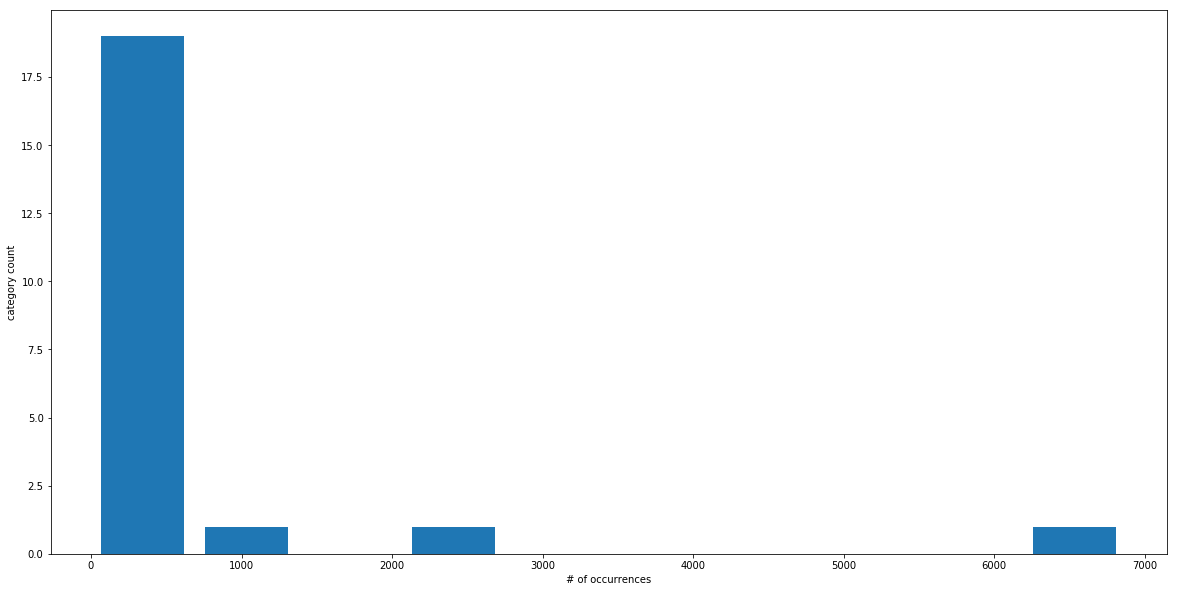

In [40]:
first_top_cat = top_cat_df.columns.get_values()[top_cat_df.columns.get_loc('avg_rating') + 1]
last_top_cat = top_cat_df.columns.get_values()[top_cat_df.columns.get_loc('Total') - 1]
fig, ax = plt.subplots(figsize=[20,10])

n, bins, patches = ax.hist(
    top_cat_df.loc[:,first_top_cat:last_top_cat].sum(axis=0),
    rwidth=0.8
)
ax.set_xlabel('# of occurrences')
ax.set_ylabel('category count')
plt.show()

In [41]:
for i in [0, 3, 10, 30, 100]:
    print('Top-level categories with count >= {}: {}'.format(i, top_cat_df.loc[:,first_top_cat:].sum(axis=0).ge(i).sum() - 1))

Top-level categories with count >= 0: 22
Top-level categories with count >= 3: 13
Top-level categories with count >= 10: 9
Top-level categories with count >= 30: 9
Top-level categories with count >= 100: 5


In [42]:
# drop the top-level categories that didn't occur, and see what's left
top_cat_df = top_cat_df.loc[:, (top_cat_df != 0).any(axis=0)]
first_top_cat = top_cat_df.columns.get_values()[top_cat_df.columns.get_loc('avg_rating') + 1]
print('Top-level categories remaining:\n{}'.format(top_cat_df.loc[:,first_top_cat:'Total'].sum(axis=0) ))

Top-level categories remaining:
active                  218.0
arts                    115.0
auto                      5.0
beautysvc                 1.0
education                 3.0
eventservices            99.0
food                   2192.0
health                    2.0
hotelstravel              3.0
localflavor              56.0
localservices             5.0
nightlife              1076.0
pets                      2.0
publicservicesgovt       33.0
restaurants            6876.0
shopping                 34.0
Total                 10720.0
dtype: float64


It looks like it would be reasonable to combine all the top-level categories with count < 30 into a new top-level category called 'services'. Before we do that, let's take a look at the second-level categories.

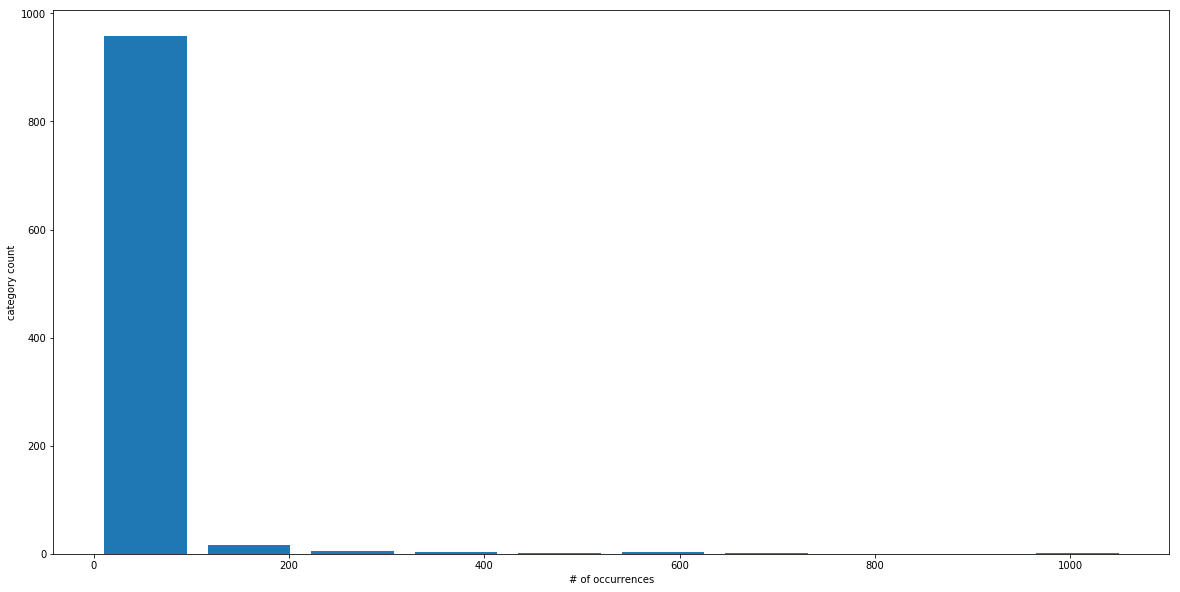

In [43]:
first_second_cat = second_cat_df.columns.get_values()[second_cat_df.columns.get_loc('Longitude') + 1]
last_second_cat = second_cat_df.columns.get_values()[second_cat_df.columns.get_loc('Total') - 1]
fig, ax = plt.subplots(figsize=[20,10])

n, bins, patches = ax.hist(
    second_cat_df.loc[:,first_second_cat:last_second_cat].sum(axis=0),
    rwidth=0.8
)
ax.set_xlabel('# of occurrences')
ax.set_ylabel('category count')
plt.show()

In [44]:
for i in [0, 3, 10, 30, 100]:
    print('Second-level categories with count >= {}: {}'.format(i, second_cat_df.loc[:,first_second_cat:].sum(axis=0).ge(i).sum() - 1))

Second-level categories with count >= 0: 994
Second-level categories with count >= 3: 163
Second-level categories with count >= 10: 114
Second-level categories with count >= 30: 70
Second-level categories with count >= 100: 37


So there are only 222 different business types in the data returned for the GTA. Half of them have less than 10 occurrences in the Yelp data. Let's drop the categories that had no occurrences and take a closer look at the remaining categories.

In [45]:
# drop the second-level categories that didn't occur, and see what's left
second_cat_df = second_cat_df.loc[:, (second_cat_df).any(axis=0)]
first_second_cat = second_cat_df.columns.get_values()[second_cat_df.columns.get_loc('Longitude') + 1]
print('Second-level categories remaining:\n{}'.format(second_cat_df.loc[:,first_second_cat:].sum(axis=0).sort_values() ))

Second-level categories remaining:
mountainbiking                 1.0
cideries                       1.0
postoffices                    1.0
rafting                        1.0
supperclubs                    1.0
fondue                         1.0
floraldesigners                1.0
stadiumsarenas                 1.0
fleamarkets                    1.0
popuprestaurants               1.0
recreation                     1.0
escapegames                    1.0
diyfood                        1.0
cannabis_clinics               1.0
scottish                       1.0
casinos                        1.0
czech                          1.0
custommerchandise              1.0
shoppingcenters                1.0
sports_clubs                   1.0
poolbilliards                  1.0
popupshops                     1.0
homeandgarden                  1.0
teambuilding                   1.0
tattoo                         1.0
antiques                       1.0
nicaraguan                     1.0
observatories       

From the most common categories, it looks like we can usefully break down 'bars' and 'chinese' into finer categories, the others don't have useful sub-categories.

Let's not worry about trying to consolidate the second-level categories with smaller counts. If our entrepreneur selects one of those, we can display a warning that there may be insufficient data for a good recommendation.

Unfortunately, breaking down a second-level category means that we need the third-level category information, but we didn't save this when we did the Yelp sampling. So we will need to repeat the scan, first we will rearrange the Yelp category tree to consolidate the low-count top-level categories, and promote 'bars' and 'chinese' into top-level categories.

In [46]:
def findCategoryWithAlias(categories, alias):
    for cat in categories:
        if cat['alias'] == alias:
            return cat
        
# promote 'bars' and 'chines' to the top level
findCategoryWithAlias(categories, 'bars')['parents'] = []
findCategoryWithAlias(categories, 'chinese')['parents'] = []

# create a new top level categories 'services'
cat = {
    'alias': 'services',
    'title': 'Services',
    'parents': []
}
categories.append(cat)

# push the categories 'auto', 'beautysvc', 'education', 'health', 'hotelstravel', 'localservices', 'pets'
# to the second level, beneath 'services'
for alias in ['auto', 'beautysvc', 'education', 'health', 'hotelstravel', 'localservices', 'pets']:
    cat = findCategoryWithAlias(categories, alias)
    cat['parents'] = ['services']
    
# rebuild the category map
(cat_alias_map, top_categories, second_categories) = build_categories_map(categories)
print('Nodes added {}, top-level categories {}, second-level categories {}'.format(
    len(cat_alias_map),
    len(top_categories),
    len(second_categories)
))

Nodes added 1566, top-level categories 18, second-level categories 745


In [48]:
# repeat the scan using the new categories map
parms = ScanParms(YELP_SEARCH_LIMIT, postal_codes, map_fsas, False)
results = ScanResults(postal_codes, top_categories, second_categories)
qc = ScanQualityControl()
scratch = Scratch()

scan_area(gta_bounds, hex_scan_geo, is_in_GTA, functools.partial(scan_sampler, parms, results, qc, scratch))

# whew, let's save that so we may never need to do it again!
results.save('_recat')

# and print the quality controls
qc.report()

API calls sent: 723
API calls throttled: 0
API calls returned error: 0
API calls returned no results: 0

Total searches: 563
Searches overflowed: 0
Max search results: 977

Businesses returned: 15648
Duplicate businesses: 5769
Businesses missing postal code: 56
Businesses outside GTA: 667
Businesses with non-neighbourhood postal code: 1
Businesses with unknown postal code: 2
Businesses with no categories: 3
Businesses that have closed: 0

Businesses stored: 9150
Businesses with no price level: 2799
Businesses with no rating: 0
Businesess with no location: 0
Unknown postal codes: {'M2A', 'M4I'}
Unknown categories: set()


Or, we can skip the scan above and load saved results if they're available.

In [47]:
results.load('_recat')

Repeat the analysis of the results.

In [48]:
(top_cat_df, second_cat_df) = results.getDataFrames(neighbourhood_df)

print(top_cat_df.shape)
top_cat_df.head()

(96, 26)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,avg_price_level,avg_rating,active,arts,bars,bicycles,chinese,eventservices,financialservices,food,homeservices,localflavor,massmedia,nightlife,professional,publicservicesgovt,religiousorgs,restaurants,services,shopping,Total
M1B,M1B,Scarborough,"Rouge,Malvern",43.811525,-79.195517,1.446809,3.031646,4.0,0.0,4.0,0.0,4.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,90.0
M1C,M1C,Scarborough,"Port Union,Rouge Hill,Highland Creek",43.785730,-79.158750,1.750000,3.607143,3.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,31.0
M1E,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.765690,-79.175256,1.705882,3.116071,3.0,0.0,6.0,0.0,6.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,69.0
M1G,M1G,Scarborough,Woburn,43.768359,-79.217590,1.600000,3.384615,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,16.0
M1H,M1H,Scarborough,Cedarbrae,43.769688,-79.239440,1.404762,3.521429,0.0,0.0,6.0,0.0,6.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,0.0,0.0,83.0


In [49]:
top_cat_df.describe()

,Latitude,Longitude,avg_price_level,avg_rating,active,arts,bars,bicycles,chinese,eventservices,financialservices,food,homeservices,localflavor,massmedia,nightlife,professional,publicservicesgovt,religiousorgs,restaurants,services,shopping,Total
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0,96.000000,96.000000,96.0,96.000000,96.0,96.000000,96.0,96.000000,96.0,96.000000,96.0,96.000000,96.000000,96.000000,96.000000
mean,43.708726,-79.395705,1.691842,3.392972,2.270833,1.197917,11.041667,0.0,6.510417,1.031250,0.0,22.833333,0.0,0.583333,0.0,1.104167,0.0,0.343750,0.0,67.843750,0.218750,0.354167,115.333333
std,0.052309,0.096929,0.156884,0.202816,2.673374,2.378057,16.597347,0.0,13.442270,1.402653,0.0,21.234860,0.0,1.120777,0.0,2.573055,0.0,0.880528,0.0,57.612559,0.619051,0.807585,107.009263
min,43.601131,-79.584701,1.307692,2.857143,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,3.000000
25%,43.664593,-79.463985,1.571255,3.271037,0.750000,0.000000,2.000000,0.0,1.750000,0.000000,0.0,7.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,28.000000,0.000000,0.000000,44.000000
50%,43.706195,-79.394378,1.696429,3.397487,1.000000,0.000000,5.000000,0.0,3.500000,1.000000,0.0,16.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,54.500000,0.000000,0.000000,83.500000
75%,43.749574,-79.334666,1.801087,3.501344,3.000000,1.250000,12.750000,0.0,6.000000,1.000000,0.0,30.250000,0.0,1.000000,0.0,1.000000,0.0,0.000000,0.0,90.250000,0.000000,0.000000,152.250000
max,43.834215,-79.158750,2.135135,3.861111,15.000000,15.000000,105.000000,0.0,81.000000,6.000000,0.0,105.000000,0.0,5.000000,0.0,15.000000,0.0,5.000000,0.0,351.000000,4.000000,4.000000,628.000000


In [50]:
print(second_cat_df.shape)
second_cat_df.head()

(96, 751)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,absinthebars,acaibowls,accountants,adult,adultentertainment,advertising,afghani,african,afrobrazilian,airportlounges,airsoft,amateursportsteams,amusementparks,andalusian,antiques,aquariums,arabian,arcades,archery,architects,argentine,armenian,artconsultants,artificialturf,artsandcrafts,asianfusion,asturian,atvrentals,auctionhouses,australian,austrian,authorized_postal_representative,auto,axethrowing,baby_gear,backshop,badminton,bagels,baguettes,bakeries,balloonservices,bangladeshi,banks,barcrawl,bartenders,baseballfields,basketballcourts,basque,bathing_area,batterystores,battingcages,bavarian,bbq,beachbars,beachequipmentrental,beaches,beachvolleyball,beautysvc,beer_and_wine,beerbar,beergarden,beergardens,beerhall,beisl,belgian,bento,bespoke,bettingcenters,beverage_stores,bicyclepaths,bikeassociations,bikeparking,bikerentals,bikerepair,bikeshop,billingservices,bingo,bistros,blacksea,blinds,boatcharters,boating,boatrepair,bobsledding,bocceball,bookkeepers,bowling,brasseries,brazilian,breakfast_brunch,breweries,brewingsupplies,bridal,british,bubblesoccer,bubbletea,buddhist_temples,buffets,buildingsupplies,bulgarian,bungeejumping,burgers,burmese,businessconsulting,businessfinancing,butcher,cabaret,cabinetry,cafes,cafeteria,cajun,cakeshop,cambodian,cannabisdispensaries,canteen,cantonese,canyoneering,careercounseling,caribbean,caricatures,carousels,carpenters,carpeting,carpetinstallation,casinos,castles,catalan,catering,cellphoneaccessories,challengecourses,champagne_bars,cheesesteaks,chicken_wings,chickenshop,childproofing,chilean,chimneycakes,chimneysweeps,chinesebazaar,choirs,churches,churros,cideries,cigarbars,civiccenter,climbing,clowns,clubcrawl,cocktailbars,coffee,coffeeroasteries,coffeeshops,coffeeteasupplies,comedyclubs,comfortfood,commissionedartists,communitycenters,computers,concept_shops,congee,contractors,convenience,corsican,countertopinstall,countryclubs,countrydancehalls,courthouses,creperies,csa,cuban,culturalcenter,cupcakes,currencyexchange,currysausage,customcakes,custommerchandise,customsbrokers,cyclingclasses,cypriot,czech,czechslovakian,damagerestoration,danceclubs,dancerestaurants,danish,dartarenas,daycamps,debtrelief,decksrailing,delicatessen,delis,demolitionservices,departmentsofmotorvehicles,desserts,diamondbuyers,digitizingservices,dimsum,diners,dinnertheater,discgolf,discountstore,distilleries,divebars,diving,diyfood,djs,donairs,donuts,doorsales,drivethrubars,drones,drugstores,drywall,dumplings,duplicationservices,dutyfreeshops,eastern_european,eatertainment,editorialservices,education,electricians,electronics,eltern_cafes,embassy,empanadas,employmentagencies,eritrean,escapegames,ethicgrocery,ethiopian,eventplanning,excavationservices,experiences,facepainting,farmersmarket,farmingequipment,farms,fashion,fasil,fencesgates,fencing,fengshui,festivals,filipino,financialadvising,...,patentlaw,patiocoverings,pawn,paydayloans,payroll,pekinese,persian,personal_shopping,personalassistants,personalchefs,peruvian,pets,pfcomercial,photoboothrentals,photographers,photographystores,piadina,pianobars,pickleball,pita,pizza,planetarium,playgrounds,plumbing,poke,policedepartments,polish,polynesian,poolbilliards,poolcleaners,poolhalls,poolservice,popuprestaurants,popupshops,portuguese,postoffices,potatoes,poutineries,pressurewashers,pretzels,printmedia,privateinvestigation,productdesign,props,psychic_astrology,pubfood,publicadjusters,publicart,publicmarkets,publicplazas,publicrelations,pubs,pulquerias,races,racetracks,racingexperience,radiostations,rafting,raw_food,realestate,recreation,refinishing,registry_office,religiousitems,riceshop,rock_climbing,rodeo,romanian,roofing,roofinspectors,rotisserie_chicken,russian,safestores,safetyequipment,sailing,sakebars,salad,salumerie,sandwiches,saunainstallation,scandinavian,scandinaviandesign,scavengerhunts,schnitzel,scooterrentals,scottish,seafood,seasonaldecorservices,security,securitysystems,seniorcenters,serbocroatian,shangha

In [51]:
second_cat_df.describe()

,Latitude,Longitude,absinthebars,acaibowls,accountants,adult,adultentertainment,advertising,afghani,african,afrobrazilian,airportlounges,airsoft,amateursportsteams,amusementparks,andalusian,antiques,aquariums,arabian,arcades,archery,architects,argentine,armenian,artconsultants,artificialturf,artsandcrafts,asianfusion,asturian,atvrentals,auctionhouses,australian,austrian,authorized_postal_representative,auto,axethrowing,baby_gear,backshop,badminton,bagels,baguettes,bakeries,balloonservices,bangladeshi,banks,barcrawl,bartenders,baseballfields,basketballcourts,basque,bathing_area,batterystores,battingcages,bavarian,bbq,beachbars,beachequipmentrental,beaches,beachvolleyball,beautysvc,beer_and_wine,beerbar,beergarden,beergardens,beerhall,beisl,belgian,bento,bespoke,bettingcenters,beverage_stores,bicyclepaths,bikeassociations,bikeparking,bikerentals,bikerepair,bikeshop,billingservices,bingo,bistros,blacksea,blinds,boatcharters,boating,boatrepair,bobsledding,bocceball,bookkeepers,bowling,brasseries,brazilian,breakfast_brunch,breweries,brewingsupplies,bridal,british,bubblesoccer,bubbletea,buddhist_temples,buffets,buildingsupplies,bulgarian,bungeejumping,burgers,burmese,businessconsulting,businessfinancing,butcher,cabaret,cabinetry,cafes,cafeteria,cajun,cakeshop,cambodian,cannabisdispensaries,canteen,cantonese,canyoneering,careercounseling,caribbean,caricatures,carousels,carpenters,carpeting,carpetinstallation,casinos,castles,catalan,catering,cellphoneaccessories,challengecourses,champagne_bars,cheesesteaks,chicken_wings,chickenshop,childproofing,chilean,chimneycakes,chimneysweeps,chinesebazaar,choirs,churches,churros,cideries,cigarbars,civiccenter,climbing,clowns,clubcrawl,cocktailbars,coffee,coffeeroasteries,coffeeshops,coffeeteasupplies,comedyclubs,comfortfood,commissionedartists,communitycenters,computers,concept_shops,congee,contractors,convenience,corsican,countertopinstall,countryclubs,countrydancehalls,courthouses,creperies,csa,cuban,culturalcenter,cupcakes,currencyexchange,currysausage,customcakes,custommerchandise,customsbrokers,cyclingclasses,cypriot,czech,czechslovakian,damagerestoration,danceclubs,dancerestaurants,danish,dartarenas,daycamps,debtrelief,decksrailing,delicatessen,delis,demolitionservices,departmentsofmotorvehicles,desserts,diamondbuyers,digitizingservices,dimsum,diners,dinnertheater,discgolf,discountstore,distilleries,divebars,diving,diyfood,djs,donairs,donuts,doorsales,drivethrubars,drones,drugstores,drywall,dumplings,duplicationservices,dutyfreeshops,eastern_european,eatertainment,editorialservices,education,electricians,electronics,eltern_cafes,embassy,empanadas,employmentagencies,eritrean,escapegames,ethicgrocery,ethiopian,eventplanning,excavationservices,experiences,facepainting,farmersmarket,farmingequipment,farms,fashion,fasil,fencesgates,fencing,fengshui,festivals,filipino,financialadvising,firedepartments,fireplace,fireprotection,...,patentlaw,patiocoverings,pawn,paydayloans,payroll,pekinese,persian,personal_shopping,personalassistants,personalchefs,peruvian,pets,pfcomercial,photoboothrentals,photographers,photographystores,piadina,pianobars,pickleball,pita,pizza,planetarium,playgrounds,plumbing,poke,policedepartments,polish,polynesian,poolbilliards,poolcleaners,poolhalls,poolservice,popuprestaurants,popupshops,portuguese,postoffices,potatoes,poutineries,pressurewashers,pretzels,printmedia,privateinvestigation,productdesign,props,psychic_astrology,pubfood,publicadjusters,publicart,publicmarkets,publicplazas,publicrelations,pubs,pulquerias,races,racetracks,racingexperience,radiostations,rafting,raw_food,realestate,recreation,refinishing,registry_office,religiousitems,riceshop,rock_climbing,rodeo,romanian,roofing,roofinspectors,rotisserie_chicken,russian,safestores,safetyequipment,sailing,sakebars,salad,salumerie,sandwiches,saunainstallation,scandinavian,scandinaviandesign,scavengerhunts,schnitzel,scooterrentals,scottish,seafood,seasonaldecorservices,security,securitysystems,seniorcenters,serbocroatian

In [52]:
# create a map centered on Toronto
map = folium.Map(location=[gta_bounds['ctr_lat'], gta_bounds['ctr_lon']], zoom_start=11)

# add a choropleth layer, just make everything light blue for now
folium.Choropleth(
    geo_data=neighbourhood_geo,
    data=top_cat_df,
    columns=['PostalCode', 'Total'],
    key_on='properties.CFSAUID',
    fill_color='YlGn',
    fill_opacity=0.6,
    legend_name='Number of Businesses per Neighbourhood'
).add_to(map)

# draw a popup marker at the Wikipedia location of each neighbourhood
for lat, lng, postal_code, borough, neighbourhood, total in zip(
    top_cat_df['Latitude'],
    top_cat_df['Longitude'],
    top_cat_df['PostalCode'],
    top_cat_df['Borough'],
    top_cat_df['Neighbourhood'],
    top_cat_df['Total']
):

    label = '{}-{}, {} ({})'.format(postal_code, neighbourhood, borough, total)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)

# display the map
embed_map(map)

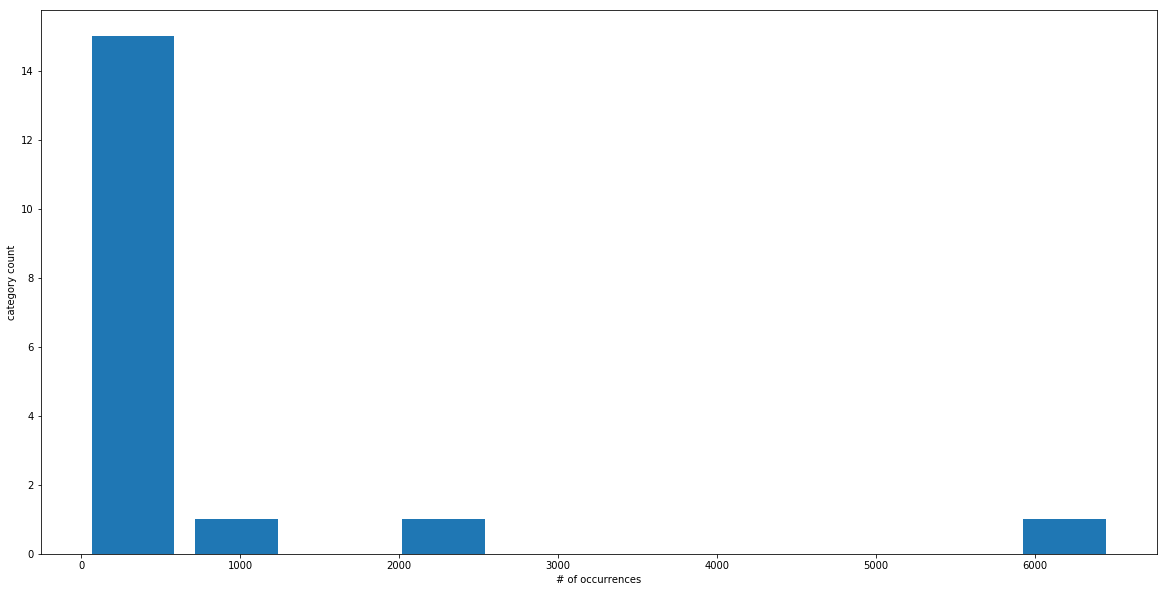

In [53]:
first_top_cat = top_cat_df.columns.get_values()[top_cat_df.columns.get_loc('avg_rating') + 1]
last_top_cat = top_cat_df.columns.get_values()[top_cat_df.columns.get_loc('Total') - 1]
fig, ax = plt.subplots(figsize=[20,10])

n, bins, patches = ax.hist(
    top_cat_df.loc[:,first_top_cat:last_top_cat].sum(axis=0),
    rwidth=0.8
)
ax.set_xlabel('# of occurrences')
ax.set_ylabel('category count')
plt.show()

In [54]:
for i in [0, 3, 10, 30, 100]:
    print('Top-level categories with count >= {}: {}'.format(i, top_cat_df.loc[:,first_top_cat:].sum(axis=0).ge(i).sum() - 1))

Top-level categories with count >= 0: 18
Top-level categories with count >= 3: 12
Top-level categories with count >= 10: 12
Top-level categories with count >= 30: 11
Top-level categories with count >= 100: 7


In [55]:
# drop the top-level categories that didn't occur, and see what's left
top_cat_df = top_cat_df.loc[:, (top_cat_df != 0).any(axis=0)]
first_top_cat = top_cat_df.columns.get_values()[top_cat_df.columns.get_loc('avg_rating') + 1]
print('Top-level categories remaining:\n{}'.format(top_cat_df.loc[:,first_top_cat:'Total'].sum(axis=0) ))

Top-level categories remaining:
active                  218.0
arts                    115.0
bars                   1060.0
chinese                 625.0
eventservices            99.0
food                   2192.0
localflavor              56.0
nightlife               106.0
publicservicesgovt       33.0
restaurants            6513.0
services                 21.0
shopping                 34.0
Total                 11072.0
dtype: float64


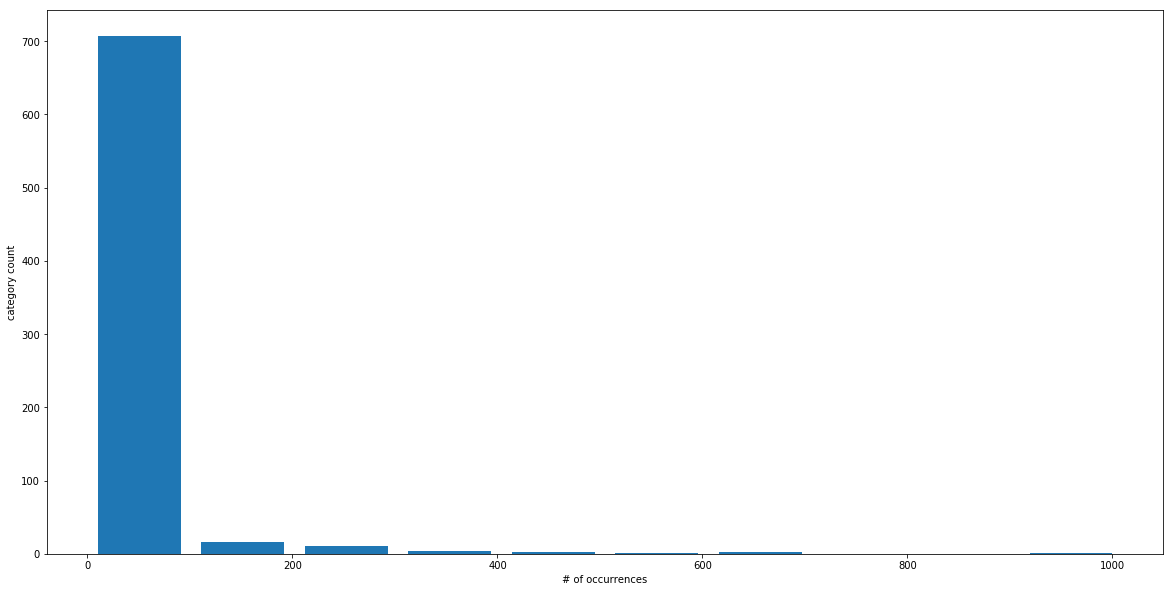

In [56]:
first_second_cat = second_cat_df.columns.get_values()[second_cat_df.columns.get_loc('Longitude') + 1]
last_second_cat = second_cat_df.columns.get_values()[second_cat_df.columns.get_loc('Total') - 1]
fig, ax = plt.subplots(figsize=[20,10])

n, bins, patches = ax.hist(
    second_cat_df.loc[:,first_second_cat:last_second_cat].sum(axis=0),
    rwidth=0.8
)
ax.set_xlabel('# of occurrences')
ax.set_ylabel('category count')
plt.show()

In [57]:
for i in [0, 3, 10, 30, 100]:
    print('Second-level categories with count >= {}: {}'.format(i, second_cat_df.loc[:,first_second_cat:].sum(axis=0).ge(i).sum() - 1))

Second-level categories with count >= 0: 745
Second-level categories with count >= 3: 177
Second-level categories with count >= 10: 122
Second-level categories with count >= 30: 75
Second-level categories with count >= 100: 39


In [58]:
# drop the second-level categories that didn't occur, and see what's left
second_cat_df = second_cat_df.loc[:, (second_cat_df).any(axis=0)]
first_second_cat = second_cat_df.columns.get_values()[second_cat_df.columns.get_loc('Longitude') + 1]
print('Second-level categories remaining:\n{}'.format(second_cat_df.loc[:,first_second_cat:].sum(axis=0).sort_values() ))

Second-level categories remaining:
fleamarkets                 1.0
homeandgarden               1.0
teambuilding                1.0
speakeasies                 1.0
fondue                      1.0
floraldesigners             1.0
tobaccoshops                1.0
shoppingcenters             1.0
sports_clubs                1.0
diyfood                     1.0
stadiumsarenas              1.0
supperclubs                 1.0
casinos                     1.0
czech                       1.0
custommerchandise           1.0
escapegames                 1.0
beautysvc                   1.0
hobbyshops                  1.0
mountainbiking              1.0
personalchefs               1.0
paintball                   1.0
observatories               1.0
poolbilliards               1.0
antiques                    1.0
nicaraguan                  1.0
popuprestaurants            1.0
popupshops                  1.0
scottish                    1.0
postoffices                 1.0
cideries                    1.0
recre

I think that gives us a better category breakdown to work with without totally reworking the Yelp categories.

Now we can do some clustering on the top-level catagories and the neighbourhood price/rating stats. First, normalise avg_price_level and avg_rating into the 0-1 range, then convert the category counts into percentages (also 0 to 1). Finally, we will normalise the entire row vector so that its magnitude is 1. This is done because I would like to use the cosine distance measure for the K-means fit, but it only supports Euclidean distance. But if all the vectors are normalised to length 1, then the two measures are proportional.

In [59]:
cluster_df = top_cat_df.loc[:, first_top_cat:last_top_cat].div(top_cat_df['Total'], axis=0)
cluster_df['avg_price_level'] = (top_cat_df['avg_price_level'] - 1) / 3      # price level is 1 to 4
cluster_df['avg_rating'] = (top_cat_df['avg_rating'] - 1) / 4                # rating is 1 to 5
print(cluster_df.shape)
cluster_df.head()

(96, 14)


,active,arts,bars,chinese,eventservices,food,localflavor,nightlife,publicservicesgovt,restaurants,services,shopping,avg_price_level,avg_rating
M1B,0.044444,0.0,0.044444,0.044444,0.000000,0.155556,0.0,0.0,0.0,0.711111,0.0,0.0,0.148936,0.507911
M1C,0.096774,0.0,0.032258,0.032258,0.000000,0.129032,0.0,0.0,0.0,0.709677,0.0,0.0,0.250000,0.651786
M1E,0.043478,0.0,0.086957,0.086957,0.014493,0.086957,0.0,0.0,0.0,0.681159,0.0,0.0,0.235294,0.529018
M1G,0.062500,0.0,0.062500,0.125000,0.062500,0.000000,0.0,0.0,0.0,0.687500,0.0,0.0,0.200000,0.596154
M1H,0.000000,0.0,0.072289,0.072289,0.000000,0.168675,0.0,0.0,0.0,0.686747,0.0,0.0,0.134921,0.630357


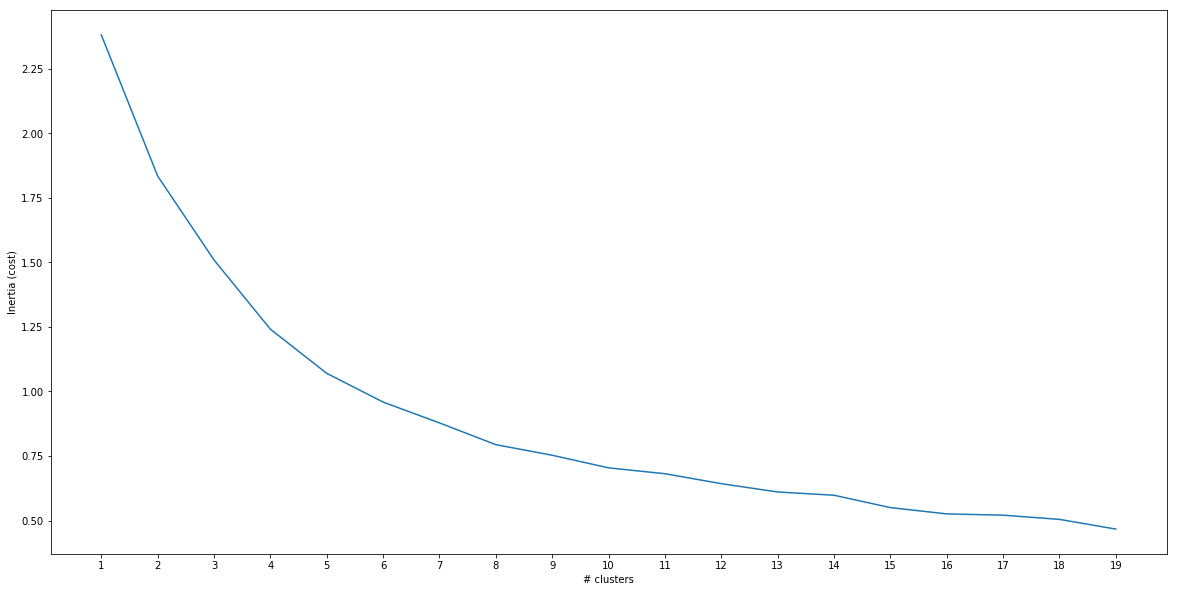

In [60]:
# find a good k-value
inertia = []
for k in range(1,20):
    kmm = KMeans(init='k-means++', n_clusters=k, n_init=12)
    kmm.fit(cluster_df)
    inertia.append(kmm.inertia_)

plt.figure(figsize=(20,10))
plt.plot(range(1,20), inertia)
plt.xticks(range(1,20))
plt.ylabel('Inertia (cost)')
plt.xlabel('# clusters')
plt.show()
    

We have the usual problem with k-means, it's subjective to pick a best value for k. Something around 6 to 11 looks reasonable. Let's histogram those values and take a closer look at the results.

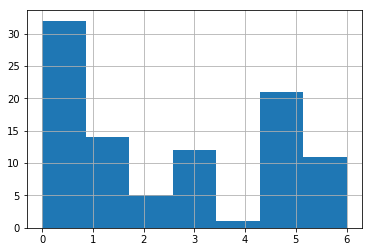

In [61]:
nClusters = 7    # try values from 6 to 11
kmm = KMeans(init='k-means++', n_clusters=nClusters, n_init=12)
kmm.fit(cluster_df)
top_cat_df['Type'] = kmm.labels_
top_cat_df['Type'].hist(bins=nClusters)
second_cat_df['Type'] = kmm.labels_

Let's go with 7 - we're always getting M2L in a cluster by itself, probably because we only found 3 businesses in that neighbourhood. It should probably be combined with one or more of its neighbours to make a better-represented neighbourhood, but this is more scope than I want to take on in the context of a course assignment. Any higher value gives us additional clusters with <5 members. Rerun the cell above one last time with n=7, and add the labels to the top-level DF.

In [62]:
# create a map centered on Toronto
map = folium.Map(location=[gta_bounds['ctr_lat'], gta_bounds['ctr_lon']], zoom_start=11)

# add a choropleth layer, just make everything light blue for now
folium.Choropleth(
    geo_data=neighbourhood_geo,
    data=top_cat_df,
    columns=['PostalCode', 'Type'],
    key_on='properties.CFSAUID',
    fill_color='Set3',
    bins=np.arange(0, nClusters+1, 1.0),
    legend_name='Neighbourhood Type',
    fill_opacity=0.6).add_to(map)

# draw a popup marker at the Wikipedia location of each neighbourhood
for lat, lng, postal_code, borough, neighbourhood, total in zip(
    top_cat_df['Latitude'],
    top_cat_df['Longitude'],
    top_cat_df['PostalCode'],
    top_cat_df['Borough'],
    top_cat_df['Neighbourhood'],
    top_cat_df['Total']
):

    label = '{}-{}, {} ({})'.format(postal_code, neighbourhood, borough, total)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)

# display the map
embed_map(map)

As a long-time Toronto resident, if not exactly a real estate or small business expert, that looks pretty reasonable. Some of the clusters are a little odd, like the one that contains Rosedale, Cabbagetown and Regent Park. But even there, strictly considering business types, there are similarities despite the disparity in housing values.

There is also the unfortunate cluster with only the M2L neighbourhood in it. Of course, we can't create any kind of predictive model for that cluster, in fact we'll set a threshold at 5 neighbourhoods, and won't create a model for any cluster smaller than that.

Now for the second phase of the machine learning, creating a predictive model for the more detailed business types in each neighbourhood type.

The process in a production application would be to perform all of the above data wrangling and clustering up front. Then a client would request a recommendation for a specific business type. At that time, we would create a linear model for each neighbourhood type to predict the number of instances of that business type in each neighbourhood, based on the top level category count.

In this prototype, we will perform this process for a couple of example business types and evaluate the results.

In [63]:
def make_linear_models(X, first_X_col, last_X_col, Y, Y_col, nClusters):
    models = []
    model_eval = {}
    for i in range(0, nClusters):
        if sum(top_cat_df['Type'] == i) < 5:
            models.append(None)
        else:
            model = LinearRegression()
            model.fit(
                X.loc[X['Type'] == i,first_X_col:last_X_col],
                Y.loc[Y['Type'] == i, Y_col]
            )
            y_pred = model.predict(X.loc[X['Type'] == i,first_X_col:last_X_col])
            mse = mean_squared_error(Y.loc[Y['Type'] == i, Y_col], y_pred)
            
            Y.loc[Y['Type'] == i, 'Predicted'] = y_pred
            Y.loc[Y['Type'] == i, 'MSE'] = mse
            Y.loc[Y['Type'] == i, 'Supply'] = (Y.loc[Y['Type'] == i, Y_col] - y_pred) / (-1.0 * max(0.1, mse))
            
            print('Type {} with count {}: explained variance (R2): {}, MSE: {}'.format(
                i,
                sum(top_cat_df['Type'] == i),
                model.score(X.loc[X['Type'] == i, first_X_col:last_X_col], Y.loc[Y['Type'] == i, Y_col]),
                mse
            ))
            models.append(model)
    return models

In [64]:
target_cat = 'fishnchips'
models = make_linear_models(top_cat_df, first_top_cat, last_top_cat, second_cat_df, target_cat, nClusters)

Type 0 with count 32: explained variance (R2): 0.4796384374551726, MSE: 0.16210482270683585
Type 1 with count 14: explained variance (R2): 0.969231124972944, MSE: 0.032652683702181926
Type 2 with count 5: explained variance (R2): 1.0, MSE: 6.774651172376541e-31
Type 3 with count 12: explained variance (R2): 1.0, MSE: 7.768174233021102e-30
Type 5 with count 21: explained variance (R2): 0.8220303232176646, MSE: 0.1848301858646478
Type 6 with count 11: explained variance (R2): 0.9885159745998111, MSE: 0.004935283643056382


The smaller neighbourhood groups look possibly overfit. The scores for the other neighbourhoods look adequate for the purpose of the implementation. If this project were to be commercialised, some investigation into alternative models (polynomial, decision tree, etc) would be warranted but in the context of a course assignment, let's keep it simple and proceed with these models.

The next step is to compare the actual count of fish 'n chips shops in each neighbour against the predicted value for that neighbourhood, and plot the results on a choropleth. We will divide the difference between the actual and predicted count for each neighbourhooed, and divide by the mean squared error of the linear model for each neighbourhood type. To avoid getting extreme ratios, or even divide-by-zero for models with low MSE, we will clip the minimum MSE at 0.1. So that the colour range on the choropleth makes more sense, and because it is not possible to invert the range of colours, we will use the negative of the ratio so that negative ratios indicate an oversupply.

Then where the absolute value of the ratio is more than 1.5 we will consider that an extreme over- or under-supply, where the absolute value is between 1.5 and 0.5, we will consider that a moderate over- or under-supply, and ratios between -0.5 and 0.5 will be considered to have just the right number of establishments for the given neighbourhood type.

For brevity, I have actually included these steps in the function above that fits the linear models.

We can now map the results.

In [65]:
def map_results(geo_df, df, target_category):
    # Replace NaNs (neighbourhoods in clusters that are too small) wihth 0.
    # Then clip the uver/under supply ratio to [-2.5, 2.5] so we don't get binning errors
    df['Supply'].fillna(0)
    df['Supply'] = df['Supply'].apply(lambda x: min(2.5, max(-2.5, x)))

    # create a map centered on Toronto
    map = folium.Map(location=[gta_bounds['ctr_lat'], gta_bounds['ctr_lon']], zoom_start=11)

    # add a choropleth layer, just make everything light blue for now
    folium.Choropleth(
        geo_data=neighbourhood_geo,
        data=df,
        columns=['PostalCode', 'Supply'],
        key_on='properties.CFSAUID',
        fill_color='RdYlBu',
        bins=[-2.5, -1.5, -0.5, 0.5, 1.5, 2.5],
        legend_name='Oversupply (red) or Undersupply (blue) of ' + target_category + ' establishments',
        fill_opacity=0.6).add_to(map)

    # draw a popup marker at the Wikipedia location of each neighbourhood
    for lat, lng, postal_code, borough, neighbourhood, predicted, actual in zip(
        geo_df['Latitude'],
        geo_df['Longitude'],
        geo_df['PostalCode'],
        geo_df['Borough'],
        geo_df['Neighbourhood'],
        df['Predicted'],
        df[target_category]
    ):

        label = '{}-{}, {} pred {:.2f}, act {:.2f}'.format(postal_code, neighbourhood, borough, predicted, actual)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map)
        
    # draw a dot at each location of the specified business type
    for loc in results.locations_by_type[target_category]:
        folium.CircleMarker(loc, radius=1, color='red', fill=True, fill_color='red', fill_opacity=1, parse_html=False).add_to(map)
        
    return map
    
map = map_results(top_cat_df, second_cat_df, target_cat)
embed_map(map)

Let's repeat the analysis assuming we want to open a sandwich shop.

In [66]:
models = make_linear_models(top_cat_df, first_top_cat, last_top_cat, second_cat_df, 'sandwiches', nClusters)
map_results(top_cat_df, second_cat_df, 'sandwiches')

Type 0 with count 32: explained variance (R2): 0.9236204958519635, MSE: 5.866826073011543
Type 1 with count 14: explained variance (R2): 0.9005775513919551, MSE: 0.958209211329576
Type 2 with count 5: explained variance (R2): 1.0, MSE: 2.8398992587956425e-29
Type 3 with count 12: explained variance (R2): 1.0, MSE: 7.084670041454499e-28
Type 5 with count 21: explained variance (R2): 0.9335008644263687, MSE: 1.5926618365730008
Type 6 with count 11: explained variance (R2): 0.9205561035997915, MSE: 0.4543403000739199


So it looks like a couple of areas in the west end and a few in the east end might be great locations for a new Subway franchise.